## Data preprocessing

In [1]:
import pandas as pd
from pathlib import Path
from datetime import datetime

# 샘플링 간격 (분)
SAMPLING_INTERVALS = {
    "12": 5,
    "16": 5,
    "17": 5,
    "21": 360
}
SOURCE_LABELS = {
    "12": "Light",
    "16": "Connectivity",
    "17": "Battery",
    "21": "Permission"
}
EIGHT_WEEKS_MINUTES = 8 * 7 * 24 * 60  # 8주

# timestamp 추출
def extract_timestamps_from_file(file_path):
    try:
        df = pd.read_csv(file_path)
        if df.empty or "timestamp" not in df.columns or df["timestamp"].dropna().empty:
            return []
        timestamps_dt = pd.to_datetime(df["timestamp"], errors="coerce").dropna()
        return timestamps_dt.tolist()
    except Exception as e:
        print(f"❌ Error parsing {file_path}: {e}")
        return []

# 누락률 계산
def compute_final_missing(timestamps_dt, interval_minutes):
    timestamps_dt.sort()
    start_time = min(timestamps_dt)
    end_time = max(timestamps_dt)
    duration_minutes = (end_time - start_time).total_seconds() / 60

    # 고유한 5분 단위로 floor한 timestamp 수
    timestamps_5min = set(pd.Series(timestamps_dt).dt.floor(f"{interval_minutes}min"))
    actual_count = len(timestamps_5min)

    expected_count = int(duration_minutes // interval_minutes) + 1
    if actual_count > expected_count:
        actual_count = expected_count

    if duration_minutes < EIGHT_WEEKS_MINUTES:
        perfect = int(EIGHT_WEEKS_MINUTES // interval_minutes)
    else:
        perfect = expected_count

    missing = max(0, perfect - actual_count)
    missing_percent = (missing / perfect) * 100 if perfect > 0 else 0.0

    return start_time, end_time, round(missing_percent, 2), actual_count, perfect

# 경로 설정
BASE_PATH = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
BATCHES = ["Batch1", "Batch2"]

records = []

for batch in BATCHES:
    batch_path = BASE_PATH / batch
    if not batch_path.exists():
        continue

    for user_folder in batch_path.iterdir():
        if not user_folder.is_dir():
            continue
        user_id = user_folder.name

        for source_num, source_label in SOURCE_LABELS.items():
            file_path = user_folder / f"source_{source_num}" / f"data_source_{source_num}.csv"
            if not file_path.exists():
                continue

            timestamps_dt = extract_timestamps_from_file(file_path)

            if len(timestamps_dt) >= 1:
                start_dt, end_dt, missing_pct, actual, expected = compute_final_missing(
                    timestamps_dt, SAMPLING_INTERVALS[source_num]
                )
                start_str = start_dt.strftime("%Y-%m-%d %H:%M:%S")
                end_str = end_dt.strftime("%Y-%m-%d %H:%M:%S")
            else:
                start_str = end_str = ""
                missing_pct = 100.0
                actual = 0
                expected = int(EIGHT_WEEKS_MINUTES // SAMPLING_INTERVALS[source_num])

            records.append({
                "Batch": batch,
                "User": user_id,
                "Source": source_label,
                "StartDate": start_str,
                "EndDate": end_str,
                "Actual Samples": actual,
                "Expected Samples": expected,
                "Final Missing %": missing_pct
            })

# 저장
df = pd.DataFrame(records)
df.to_csv("final_corrected_missing_summary.csv", index=False)
print("✅ 최종 누락률 CSV 저장 완료 → missing_percentage_all_batches.csv")

✅ 최종 누락률 CSV 저장 완료 → missing_percentage_all_batches.csv


## Visualization

### 센서별 평균 누락률 (Batch1 vs Batch2 비교)

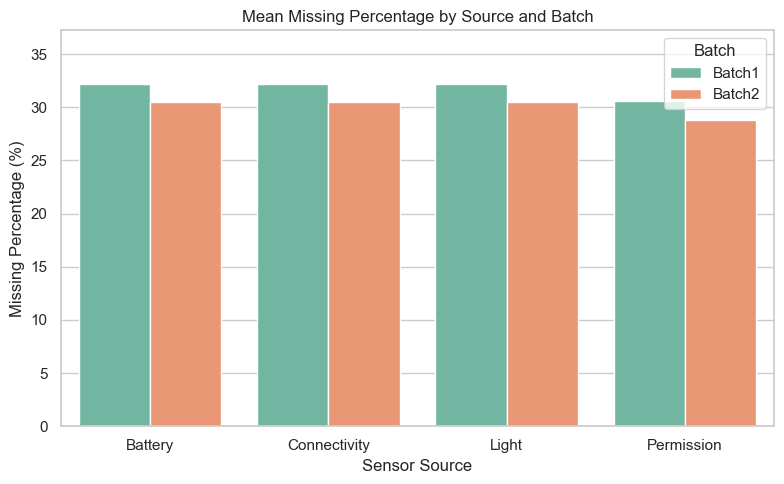

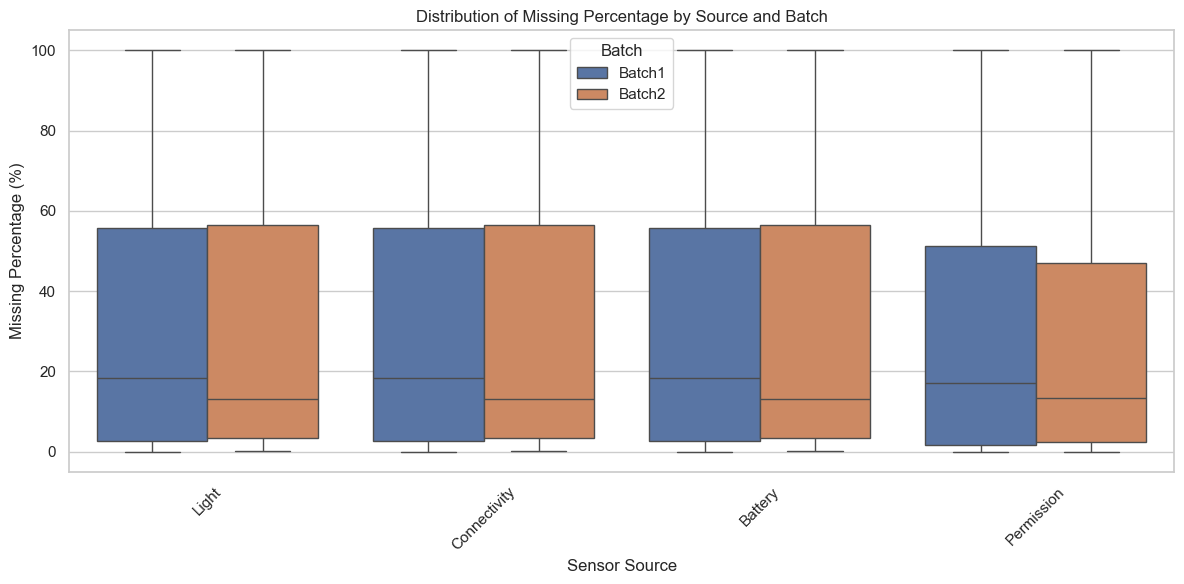

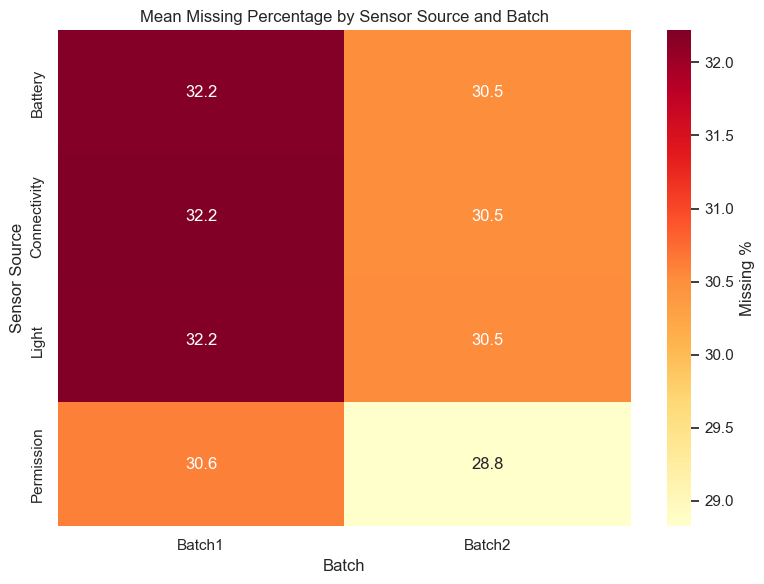


Descriptive Statistics by Source and Batch:

| Source       | Batch   |   count |   mean |   std |   min |   q25 |   median |   q75 |   max |
|:-------------|:--------|--------:|-------:|------:|------:|------:|---------:|------:|------:|
| Battery      | Batch1  |      66 |  32.19 | 35.08 |  0.04 |  2.64 |    18.4  | 55.66 |   100 |
| Battery      | Batch2  |     108 |  30.51 | 33.09 |  0.1  |  3.3  |    13.19 | 56.59 |   100 |
| Connectivity | Batch1  |      66 |  32.22 | 35.08 |  0.04 |  2.64 |    18.4  | 55.66 |   100 |
| Connectivity | Batch2  |     108 |  30.51 | 33.09 |  0.1  |  3.3  |    13.18 | 56.59 |   100 |
| Light        | Batch1  |      66 |  32.2  | 35.08 |  0.04 |  2.64 |    18.45 | 55.67 |   100 |
| Light        | Batch2  |     108 |  30.53 | 33.07 |  0.1  |  3.3  |    13.19 | 56.59 |   100 |
| Permission   | Batch1  |      66 |  30.61 | 35.15 |  0    |  1.78 |    17.12 | 51.34 |   100 |
| Permission   | Batch2  |     108 |  28.83 | 32.61 |  0    |  2.43 |    13.33 | 

In [183]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# CSV 불러오기 (보정된 누락률이 적용된 버전)
df = pd.read_csv("final_corrected_missing_summary.csv")  # 파일 이름에 맞게 수정

# ─── 1) Source별 평균 누락률 (Batch 구분) ─────────────────────────────────
mean_missing = df.groupby(["Source", "Batch"])["Final Missing %"] \
                 .mean().reset_index()

# ─── 2) 시각화: Barplot ────────────────────────────────────────────────────
plt.figure(figsize=(8, 5))
sns.barplot(data=mean_missing, x="Source", y="Final Missing %", hue="Batch", palette="Set2")
plt.title("Mean Missing Percentage by Source and Batch")
plt.ylabel("Missing Percentage (%)")
plt.xlabel("Sensor Source")
plt.ylim(0, mean_missing["Final Missing %"].max() + 5)
plt.legend(title="Batch")
plt.tight_layout()
plt.show()

# ─── 3) 시각화: 박스플롯 ──────────────────────────────────────────────────
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Source', y='Final Missing %', hue='Batch')
plt.title("Distribution of Missing Percentage by Source and Batch")
plt.ylabel("Missing Percentage (%)")
plt.xlabel("Sensor Source")
plt.legend(title="Batch")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ─── 4) 시각화: 히트맵 ──────────────────────────────────────────────────
heatmap_data = df.pivot_table(
    index="Source",
    columns="Batch",
    values="Final Missing %",
    aggfunc="mean"
)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={'label': 'Missing %'})
plt.title("Mean Missing Percentage by Sensor Source and Batch")
plt.xlabel("Batch")
plt.ylabel("Sensor Source")
plt.tight_layout()
plt.show()

# ─── 5) 통계량 출력 ────────────────────────────────────────────────────────
# count, mean, std, min, 25%, 50%, 75%, max 계산
stats = df.groupby(["Source", "Batch"])["Final Missing %"].agg(
    count="count",
    mean="mean",
    std="std",
    min="min",
    q25=lambda x: x.quantile(0.25),
    median="median",
    q75=lambda x: x.quantile(0.75),
    max="max"
).round(2).reset_index()

print("\nDescriptive Statistics by Source and Batch:\n")
print(stats.to_markdown(index=False))

### 센서별 전체 평균 누락률 계산 코드 (Batch 무관)

📊 센서별 전체 평균 누락률:
Source
Light           31.160805
Connectivity    31.158678
Battery         31.148276
Permission      29.504195
Name: Final Missing %, dtype: float64


/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/955900243.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=source_mean.index, y=source_mean.values, palette='Blues_d')


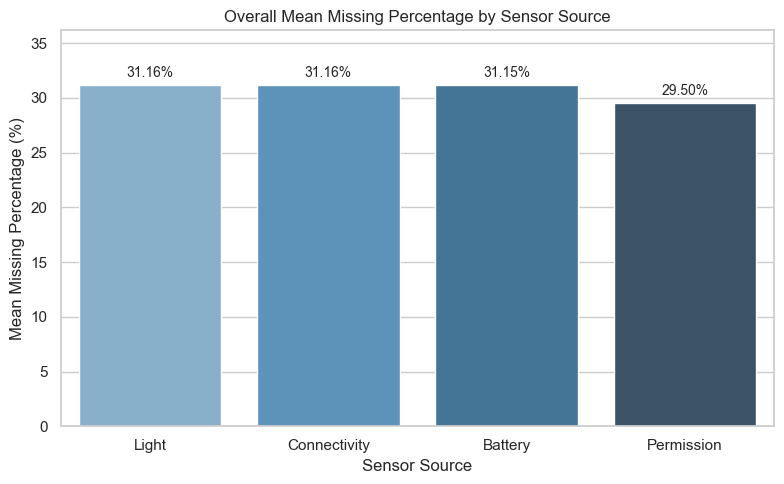

In [133]:
# 센서(Source)별 전체 평균 누락률 계산
source_mean = df.groupby('Source')['Final Missing %'].mean().sort_values(ascending=False)

# 출력
print("📊 센서별 전체 평균 누락률:")
print(source_mean)

# 시각화
plt.figure(figsize=(8, 5))
sns.barplot(x=source_mean.index, y=source_mean.values, palette='Blues_d')
# 수치(label) 표시
for i, value in enumerate(source_mean.values):
    plt.text(i, value + 0.5, f"{value:.2f}%", ha='center', va='bottom', fontsize=10)

plt.title('Overall Mean Missing Percentage by Sensor Source')
plt.ylabel('Mean Missing Percentage (%)')
plt.xlabel('Sensor Source')
plt.ylim(0, max(source_mean.values) + 5)
plt.tight_layout()
plt.show()

### 사용자별 누락률 분포 분석

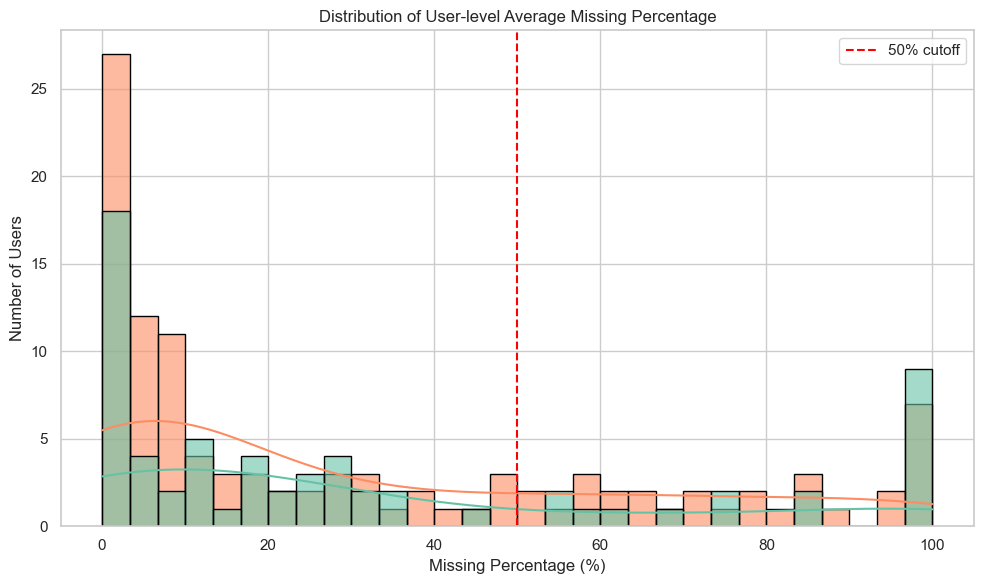

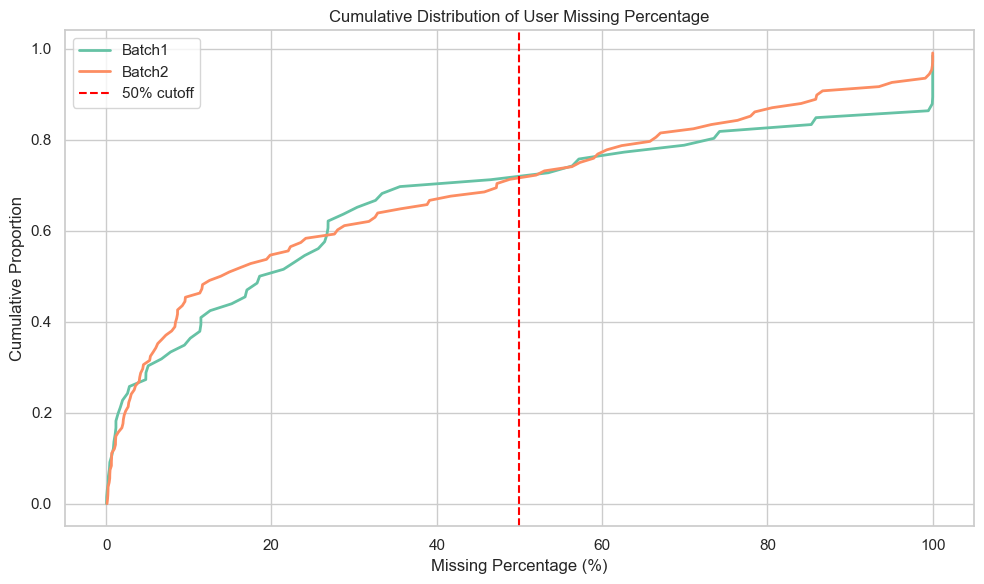


📋 Batch-wise Missing % Descriptive Statistics:
        count   mean    std   min   25%    50%    75%    max
Batch                                                       
Batch1   66.0  32.20  35.08  0.04  2.64  18.41  55.66  100.0
Batch2  108.0  30.52  33.08  0.10  3.30  13.19  56.59  100.0

📊 50% Cutoff Summary by Batch:
        TotalUsers  NumAbove50  NumBelow50  PctAbove50 (%)  PctBelow50 (%)
Batch                                                                     
Batch1          66          18          48            27.3            72.7
Batch2         108          30          78            27.8            72.2


In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 Permission 소스 제외
df = df[df['Source'] != 'Permission']

# 사용자당 평균 누락률 계산
user_missing = df.groupby(['Batch', 'User'])['Final Missing %'].mean().reset_index()

# ───(시각화 코드 생략)───────────────────────────────────────────────────

# ▶ 히스토그램+KDE
plt.figure(figsize=(10, 6))
sns.histplot(data=user_missing, x='Final Missing %', hue='Batch', kde=True,
             bins=30, palette='Set2', edgecolor='black', alpha=0.6)
plt.axvline(50, color='red', linestyle='--', label='50% cutoff')
plt.title('Distribution of User-level Average Missing Percentage')
plt.xlabel('Missing Percentage (%)')
plt.ylabel('Number of Users')
plt.legend()
plt.tight_layout()
plt.show()
palette = sns.color_palette("Set2", n_colors=user_missing['Batch'].nunique())

# ▶ 누적분포
plt.figure(figsize=(10, 6))
for (batch, color) in zip(sorted(user_missing['Batch'].unique()), palette):
    subset = user_missing[user_missing['Batch'] == batch]['Final Missing %']
    x = np.sort(subset)
    y = np.arange(len(x)) / float(len(x))
    plt.plot(x, y, label=batch, color=color, linewidth=2)
plt.axvline(50, color='red', linestyle='--', label='50% cutoff')
plt.title('Cumulative Distribution of User Missing Percentage')
plt.xlabel('Missing Percentage (%)')
plt.ylabel('Cumulative Proportion')
plt.legend()
plt.tight_layout()
plt.show()

# ─── 로그로 통계표 출력 ───────────────────────────────────────────────────

# 1) 배치별 요약 통계
stats = user_missing.groupby('Batch')['Final Missing %'].describe().round(2)
print("\n📋 Batch-wise Missing % Descriptive Statistics:")
print(stats)

# 2) 50% 컷오프 기준 위/아래 사용자 수·비율
total = user_missing.groupby('Batch').size().rename('TotalUsers')
above50 = user_missing[user_missing['Final Missing %'] >= 50].groupby('Batch').size().rename('NumAbove50')
below50 = user_missing[user_missing['Final Missing %'] < 50].groupby('Batch').size().rename('NumBelow50')

summary = pd.concat([total, above50, below50], axis=1).fillna(0).astype(int)
summary['PctAbove50 (%)'] = (summary['NumAbove50'] / summary['TotalUsers'] * 100).round(1)
summary['PctBelow50 (%)'] = (summary['NumBelow50'] / summary['TotalUsers'] * 100).round(1)

print("\n📊 50% Cutoff Summary by Batch:")
print(summary.to_string())

In [136]:
# user_missing 은 앞서 계산한 DataFrame:
#   Batch | User       | Final Missing %
#  -------+------------+----------------
#   Batch1| cmp1_usr541|  5.23
#   Batch1| cmp1_usr542| 82.15
#   ...

import pandas as pd

# 1) 배치별로 평균 누락률 정렬 출력
for batch in ['Batch1', 'Batch2']:
    sub = user_missing[user_missing['Batch'] == batch] \
              .sort_values('Final Missing %', ascending=False) \
              .reset_index(drop=True)
    print(f"\n── {batch} ──")
    print(sub[['User', 'Final Missing %']].to_string(index=False))

# 2) 50% 컷오프 초과 유저 ID 리스트
above = user_missing[user_missing['Final Missing %'] >= 50]
print("\n── High-Missing Users (>=50%) ──")
for batch in ['Batch1', 'Batch2']:
    ids = above[above['Batch'] == batch]['User'].tolist()
    print(f"{batch} ({len(ids)}명): {ids}")


── Batch1 ──
       User  Final Missing %
cmp1_usr597       100.000000
cmp1_usr618       100.000000
cmp1_usr608       100.000000
cmp1_usr613       100.000000
cmp1_usr584       100.000000
cmp1_usr542       100.000000
cmp1_usr621       100.000000
cmp1_usr617        99.946667
cmp1_usr645        99.470000
cmp1_usr601        85.880000
cmp1_usr652        85.310000
cmp1_usr588        74.210000
cmp1_usr631        73.530000
cmp1_usr639        69.920000
cmp1_usr590        62.673333
cmp1_usr646        57.190000
cmp1_usr596        56.386667
cmp1_usr616        53.480000
cmp1_usr594        46.530000
cmp1_usr545        35.550000
cmp1_usr586        33.380000
cmp1_usr649        32.590000
cmp1_usr603        30.370000
cmp1_usr582        28.700000
cmp1_usr622        26.850000
cmp1_usr643        26.840000
cmp1_usr619        26.700000
cmp1_usr640        26.430000
cmp1_usr571        25.660000
cmp1_usr624        24.013333
cmp1_usr626        22.740000
cmp1_usr559        21.450000
cmp1_usr651        18.566667


/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/72485975.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.boxplot(
/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/72485975.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc='upper right')


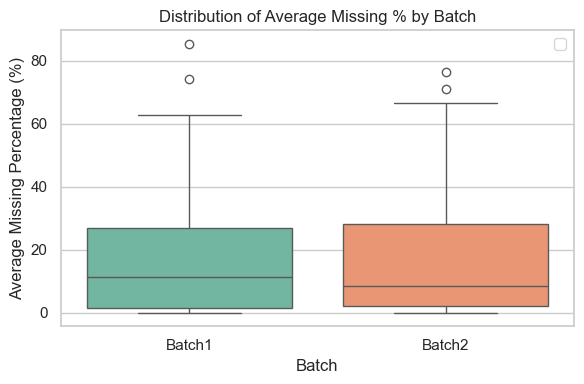

/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/72485975.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(


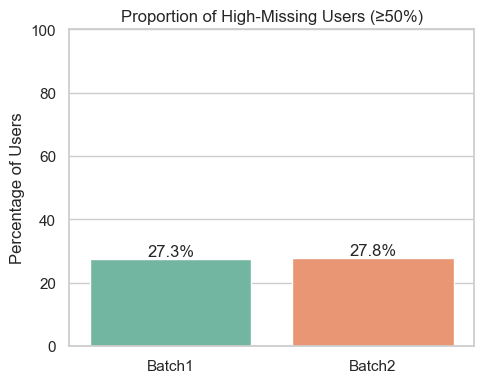

        count   mean    std   min   25%    50%   75%    max
Batch                                                      
Batch1   54.0  18.45  20.59  0.04  1.50  11.46  26.8  85.31
Batch2   88.0  17.79  20.56  0.10  2.32   8.46  28.2  76.39


In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

# user_missing: DataFrame with ['Batch','User','Final Missing %']
# summary: 위에서 만든 50% 컷오프 요약 테이블 (columns=['Batch','TotalUsers','NumAbove50','PctAbove50 (%)'])

sns.set(style="whitegrid")

# ─── (1) Boxplot: 배치별 누락률 분포 ──────────────────────────────────────
dropout_user_ids_batch1 = [542, 584, 597, 601, 608, 613, 617, 618, 621, 631, 639, 645]
dropout_user_ids_batch2 = [662, 663, 666, 669, 682, 683, 689, 701, 704, 716, 723, 725, 726, 727, 736, 746, 756, 765, 767, 769]
dropouts = (
    [f"cmp1_usr{uid}" for uid in dropout_user_ids_batch1] +
    [f"cmp1_usr{uid}" for uid in dropout_user_ids_batch2]
)

# dropout 사용자 제거
filtered_user_missing = user_missing[~user_missing['User'].isin(dropouts)]
plt.figure(figsize=(6,4))
ax1 = sns.boxplot(
    data=filtered_user_missing,
    x='Batch', y='Final Missing %',
    palette=['#66C2A5','#FC8D62']
)
#ax1.axhline(50, color='red', linestyle='--', label='50% cutoff')
ax1.set_title('Distribution of Average Missing % by Batch')
ax1.set_ylabel('Average Missing Percentage (%)')
ax1.legend(loc='upper right')
plt.tight_layout()
plt.show()

# ─── (2) Barplot: 50% 컷오프 초과 비율 ───────────────────────────────────
plt.figure(figsize=(5,4))
ax2 = sns.barplot(
    data=summary,
    x='Batch', y='PctAbove50 (%)',
    palette=['#66C2A5','#FC8D62']
)
for i, v in enumerate(summary['PctAbove50 (%)']):
    ax2.text(i, v + 1, f"{v:.1f}%", ha='center')
ax2.set_ylim(0,100)
ax2.set_title('Proportion of High-Missing Users (≥50%)')
ax2.set_ylabel('Percentage of Users')
ax2.set_xlabel('')
plt.tight_layout()
plt.show()
# 🔹 배치별 기초 통계량 계산
summary_stats = (
    filtered_user_missing
    .groupby("Batch")["Final Missing %"]
    .describe()
    .loc[:, ["count", "mean", "std", "min", "25%", "50%", "75%", "max"]]
    .round(2)
)

# 🔹 출력
print(summary_stats)

#### 전체 사용자 대상 Weekly dropout rate

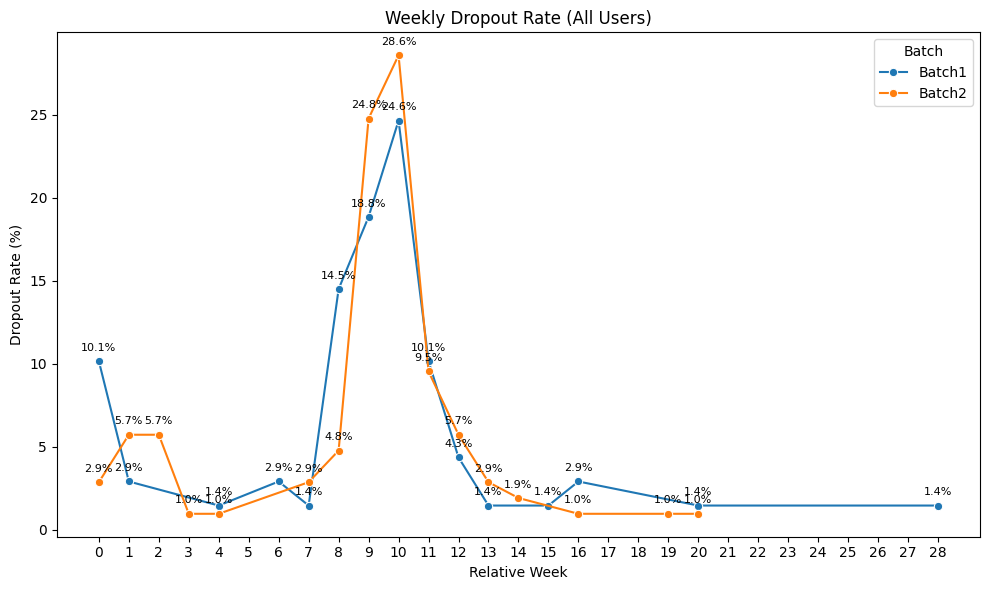

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 weekly_sample_map: {user_id: {week: sample_count, ...}}
# 전제: sample count가 0인 첫 주가 dropout으로 간주됨

# 🔹 사용자의 dropout 주차 계산
def get_user_dropout_weeks(weekly_sample_map):
    records = []
    for user_id in weekly_sample_map:
        weeks = weekly_sample_map[user_id]

        if not weeks:  # 데이터가 아예 없음 → 1주차 dropout
            drop_week = 0
        else:
            sorted_weeks = sorted(weeks.items())
            for week, count in sorted_weeks:
                if count == 0:
                    drop_week = week
                    break
            else:
                drop_week = max(weeks.keys()) + 1  # 끝까지 수집한 경우

        batch = "Batch1" if int(user_id.split("usr")[-1]) < 660 else "Batch2"
        records.append({
            "User": user_id,
            "DropWeek": drop_week,
            "Batch": batch
        })

    return pd.DataFrame(records)

# 🔹 주차별 이탈률 계산
drop_weeks_all = get_user_dropout_weeks(weekly_sample_map)
drop_counts = drop_weeks_all.groupby(['Batch', 'DropWeek'])['User'].count().reset_index(name='UserCount')

# 🔹 비율 계산
batch_totals = drop_weeks_all.groupby('Batch')['User'].nunique().to_dict()
drop_counts['DropoutRate (%)'] = drop_counts.apply(
    lambda row: (row['UserCount'] / batch_totals[row['Batch']]) * 100, axis=1
)

# 🔹 시각화
plt.figure(figsize=(10, 6))
sns.lineplot(data=drop_counts, x='DropWeek', y='DropoutRate (%)', hue='Batch', marker='o')

# 🔹 주석 추가
for i in range(len(drop_counts)):
    row = drop_counts.iloc[i]
    plt.text(row['DropWeek'], row['DropoutRate (%)'] + 0.5, f"{row['DropoutRate (%)']:.1f}%", 
             ha='center', va='bottom', fontsize=8, color='black')

# 🔹 스타일 정리
plt.title("Weekly Dropout Rate (All Users)")
plt.xlabel("Relative Week")
plt.ylabel("Dropout Rate (%)")
plt.xticks(range(int(drop_weeks_all['DropWeek'].min()), int(drop_weeks_all['DropWeek'].max()) + 1))
plt.legend(title='Batch')
plt.tight_layout()
plt.show()

#### 전체 사용자 대상 weekly data submission rate

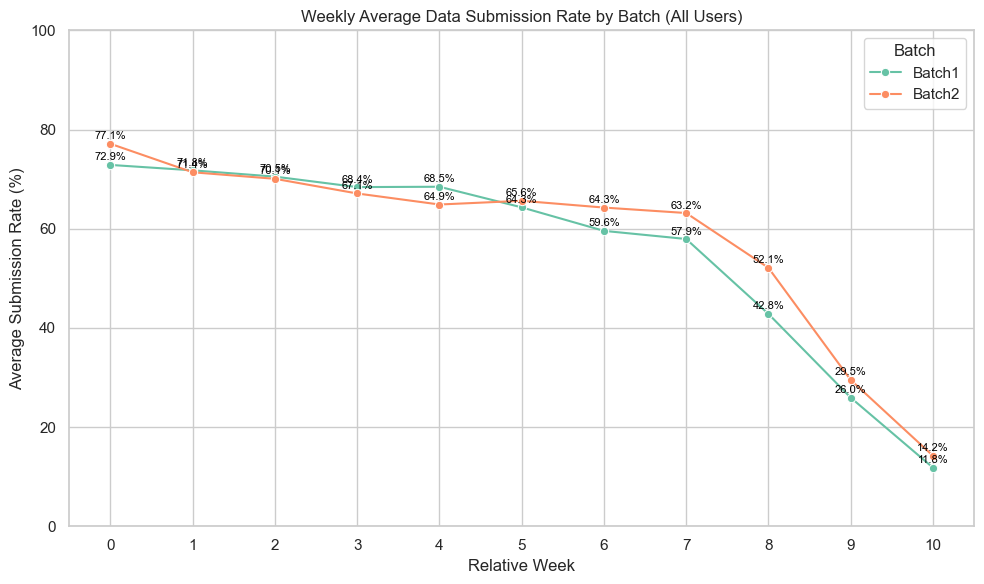

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ─── 기본 설정 ───────────────────────────────────────────────────────────────
BASE_PATH = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
BATCHES = ["Batch1", "Batch2"]
SENSOR_FOLDER = "source_12"
SENSOR_FILE = "data_source_12.csv"

# 주당 기대 샘플 수 (5분마다 1회 → 7*24*60/5)
EXPECTED_SAMPLES_PER_WEEK = (7 * 24 * 60) // 5  # = 2016

sns.set(style="whitegrid")

# ─── 사용자별 주차별 샘플 수 맵 생성 함수 ────────────────────────────────────
def build_weekly_sample_map():
    user_week_map = {}
    for batch in BATCHES:
        for user_folder in (BASE_PATH / batch).glob("cmp1_usr*"):
            uid = user_folder.name
            csv_path = user_folder / SENSOR_FOLDER / SENSOR_FILE
            if not csv_path.exists():
                user_week_map[uid] = {}
                continue

            df = pd.read_csv(csv_path, usecols=["timestamp"])
            if df.empty:
                user_week_map[uid] = {}
                continue

            # 타임스탬프 파싱 & 중복제거
            df["ts"] = pd.to_datetime(df["timestamp"], errors="coerce")
            df = df.dropna(subset=["ts"]).drop_duplicates(["ts"])
            if df.empty:
                user_week_map[uid] = {}
                continue

            start = df["ts"].min()
            # 상대주차 계산
            df["week"] = ((df["ts"] - start).dt.days // 7).astype(int)
            # 5분보다 짧은 간격 중복 제거
            def count_valid(xs):
                xs = xs.sort_values()
                last = xs.iloc[0]
                cnt = 1
                for x in xs.iloc[1:]:
                    if (x - last).total_seconds() >= 300:
                        cnt += 1
                        last = x
                return cnt

            weekly_counts = (
                df.groupby("week")["ts"]
                  .apply(count_valid)
                  .to_dict()
            )
            user_week_map[uid] = weekly_counts

    return user_week_map

# ─── Batch 추정 함수 ───────────────────────────────────────────────────────
def infer_batch(uid):
    # 사용자 번호 1~659 → Batch1, 그 이후 → Batch2
    num = int(uid.replace("cmp1_usr", ""))
    return "Batch1" if num < 660 else "Batch2"

# ─── 주차별 평균 제출률 계산 ───────────────────────────────────────────────
def compute_weekly_submission_rate(user_week_map):
    # 전체 주차 리스트
    all_weeks = sorted({w for weeks in user_week_map.values() for w in weeks})

    records = []
    for week in all_weeks:
        for batch in BATCHES:
            # 해당 배치의 모든 사용자
            uids = [uid for uid in user_week_map if infer_batch(uid) == batch]
            rates = []
            for uid in uids:
                cnt = user_week_map[uid].get(week, 0)
                rates.append(cnt / EXPECTED_SAMPLES_PER_WEEK)
            avg_rate = np.mean(rates) if rates else 0.0
            records.append({
                "Week": week,
                "Batch": batch,
                "AvgSubmissionRate": avg_rate * 100
            })

    return pd.DataFrame(records)

# ─── 메인 실행 ────────────────────────────────────────────────────────────
if __name__ == "__main__":
    user_week_map = build_weekly_sample_map()
    df_sub = compute_weekly_submission_rate(user_week_map)
    df_sub = df_sub[df_sub["Week"] <= 10]
    # 시각화
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=df_sub,
        x="Week", y="AvgSubmissionRate",
        hue="Batch", marker="o", palette="Set2"
    )
    # 라벨링
    for _, row in df_sub.iterrows():
        plt.text(
            row["Week"], row["AvgSubmissionRate"] + 0.5,
            f"{row['AvgSubmissionRate']:.1f}%",
            ha="center", va="bottom", fontsize=8, color="black"
        )

    plt.title("Weekly Average Data Submission Rate by Batch (All Users)")
    plt.xlabel("Relative Week")
    plt.ylabel("Average Submission Rate (%)")
    plt.ylim(0, 100)
    plt.xticks(sorted(df_sub["Week"].unique()))
    plt.legend(title="Batch")
    plt.tight_layout()
    plt.show()

Loading Batch1: 66it [00:03, 19.83it/s]
Loading Batch2: 108it [00:05, 18.49it/s]


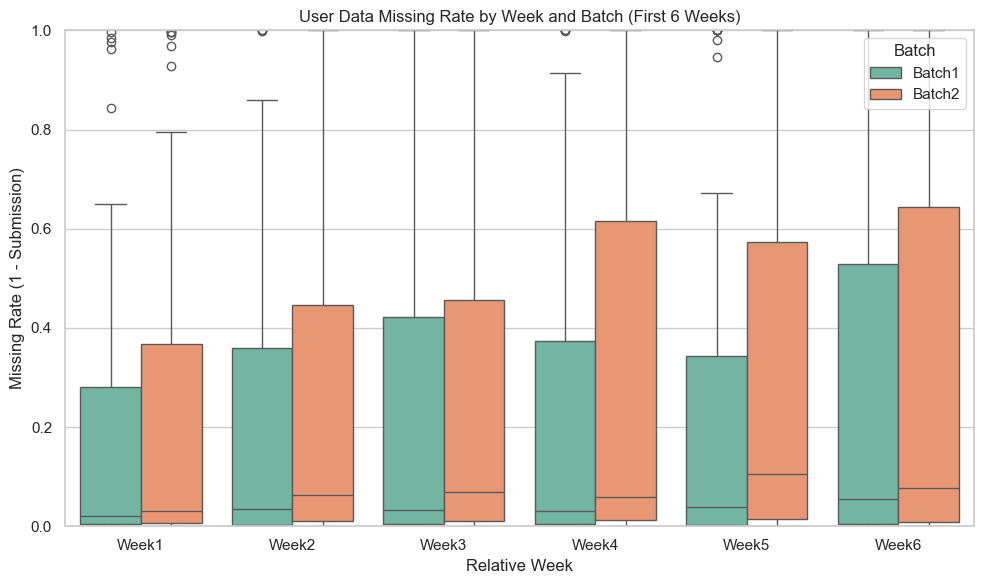

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from tqdm import tqdm

# ─── 설정 ───────────────────────────────────────────────────────────────
BASE_PATH = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
BATCHES = ["Batch1", "Batch2"]
SENSOR_FOLDER = "source_12"
SENSOR_FILE = "data_source_12.csv"
EXPECTED_SAMPLES_PER_WEEK = (7 * 24 * 60) // 5  # 2016
MAX_WEEKS = 6

sns.set(style="whitegrid")

# ─── 사용자별 주차별 샘플 수 맵 생성 ─────────────────────────────────────
def build_weekly_sample_map():
    records = []
    for batch in BATCHES:
        for user_folder in tqdm((BASE_PATH / batch).glob("cmp1_usr*"), desc=f"Loading {batch}"):
            user_id = user_folder.name
            file_path = user_folder / SENSOR_FOLDER / SENSOR_FILE
            if not file_path.exists():
                continue

            df = pd.read_csv(file_path, usecols=["timestamp"])
            df["ts"] = pd.to_datetime(df["timestamp"], errors="coerce")
            df = df.dropna(subset=["ts"]).drop_duplicates(["ts"])
            if df.empty:
                continue

            start = df["ts"].min()
            df["week"] = ((df["ts"] - start).dt.days // 7).astype(int)

            def count_valid(ts_series):
                ts_sorted = ts_series.sort_values()
                last_time = ts_sorted.iloc[0]
                count = 1
                for ts in ts_sorted.iloc[1:]:
                    if (ts - last_time).total_seconds() >= 300:
                        count += 1
                        last_time = ts
                return count

            weekly_counts = (
                df.groupby("week")["ts"]
                .apply(count_valid)
                .to_dict()
            )

            for week in range(MAX_WEEKS):
                count = weekly_counts.get(week, 0)
                missing_rate = 1 - (count / EXPECTED_SAMPLES_PER_WEEK)
                records.append({
                    "User": user_id,
                    "Batch": batch,
                    "Week": f"Week{week+1}",
                    "MissingRate": missing_rate
                })

    return pd.DataFrame(records)

# ─── 실행 및 시각화 ──────────────────────────────────────────────────────
df_box = build_weekly_sample_map()

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_box,
    x="Week", y="MissingRate", hue="Batch",
    palette="Set2"
)
plt.ylim(0, 1)
plt.title("User Data Missing Rate by Week and Batch (First 6 Weeks)")
plt.ylabel("Missing Rate (1 - Submission)")
plt.xlabel("Relative Week")
plt.tight_layout()
plt.show()

In [150]:
import pandas as pd
import numpy as np
from scipy import stats

# ─── (A) df_box 로드 ──────────────────────────────────────────────────
# df_box: columns = ['User','Batch','Week','MissingRate'] 
#          Week 값은 'Week1'부터 'Week6'까지 있어야 합니다.
# 예) df_box = pd.read_csv("boxplot_data.csv")

# ─── (B) 주차·배치별 기술통계량 계산 ────────────────────────────────────
stats_cols = ["count","mean","std","median","min","max"]
summary_stats = (
    df_box
    .groupby(["Week","Batch"])["MissingRate"]
    .agg(stats_cols)
    .round(3)
    .reset_index()
)

# ─── (C) 주차별 Z-test (두 독립그룹 unequal var t-test) ──────────────────
ztest_results = []
for wk in sorted(df_box["Week"].unique(), key=lambda x: int(x.replace("Week",""))):
    b1 = df_box[(df_box["Week"]==wk) & (df_box["Batch"]=="Batch1")]["MissingRate"]
    b2 = df_box[(df_box["Week"]==wk) & (df_box["Batch"]=="Batch2")]["MissingRate"]
    # Welch’s t-test ≒ unequal-var Z-test
    t_stat, p_val = stats.ttest_ind(b1, b2, equal_var=False)
    ztest_results.append({
        "Week": wk,
        "Z (t-stat)": round(t_stat, 3),
        "p-value": round(p_val, 3)
    })
ztest_df = pd.DataFrame(ztest_results)

# ─── (D) 결과 확인 ─────────────────────────────────────────────────────
print("▶ Weekly Descriptive Statistics by Batch:")
print(summary_stats.pivot(index="Week", columns="Batch")[stats_cols])
print("\n▶ Weekly Z-test (Batch1 vs Batch2):")
print(ztest_df)

▶ Weekly Descriptive Statistics by Batch:
       count          mean           std        median           min         \
Batch Batch1 Batch2 Batch1 Batch2 Batch1 Batch2 Batch1 Batch2 Batch1 Batch2   
Week                                                                          
Week1     59    105  0.192  0.204  0.300  0.292  0.021  0.030    0.0    0.0   
Week2     59    105  0.204  0.262  0.309  0.332  0.035  0.062    0.0    0.0   
Week3     59    105  0.218  0.275  0.316  0.360  0.034  0.068    0.0    0.0   
Week4     59    105  0.233  0.310  0.342  0.383  0.030  0.059    0.0    0.0   
Week5     59    105  0.232  0.333  0.351  0.387  0.039  0.106    0.0    0.0   
Week6     59    105  0.290  0.320  0.365  0.392  0.055  0.077    0.0    0.0   

         max         
Batch Batch1 Batch2  
Week                 
Week1  0.996  0.998  
Week2  1.000  1.000  
Week3  1.000  1.000  
Week4  1.000  1.000  
Week5  1.000  1.000  
Week6  1.000  1.000  

▶ Weekly Z-test (Batch1 vs Batch2):
    Week  Z

In [153]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 2.6 MB/s eta 0:00:00a 0:00:01m


In [154]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

# df_box: columns = ['User','Batch','Week','MissingRate']
# Week를 숫자형으로 바꿔야 합니다:
df_box['WeekNum'] = df_box['Week'].str.replace('Week','').astype(int)

# Mixed ANOVA: Random intercept per User
model = mixedlm(
    "MissingRate ~ C(Batch) * WeekNum",     # fixed effects: Batch, Week, Batch*Week
    df_box,
    groups=df_box["User"]                  # random intercept for each user
)
result = model.fit()
print(result.summary())

               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    MissingRate
No. Observations:     984        Method:                REML       
No. Groups:           164        Scale:                 0.0365     
Min. group size:      6          Log-Likelihood:        -1.3610    
Max. group size:      6          Converged:             Yes        
Mean group size:      6.0                                          
-------------------------------------------------------------------
                           Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                  0.169    0.045 3.794 0.000  0.082  0.257
C(Batch)[T.Batch2]         0.032    0.056 0.574 0.566 -0.077  0.141
WeekNum                    0.017    0.006 2.828 0.005  0.005  0.028
C(Batch)[T.Batch2]:WeekNum 0.007    0.007 0.927 0.354 -0.008  0.021
Group Var                  0.086    0.058                      

#### Normal users 대상 Weekly data submission rate

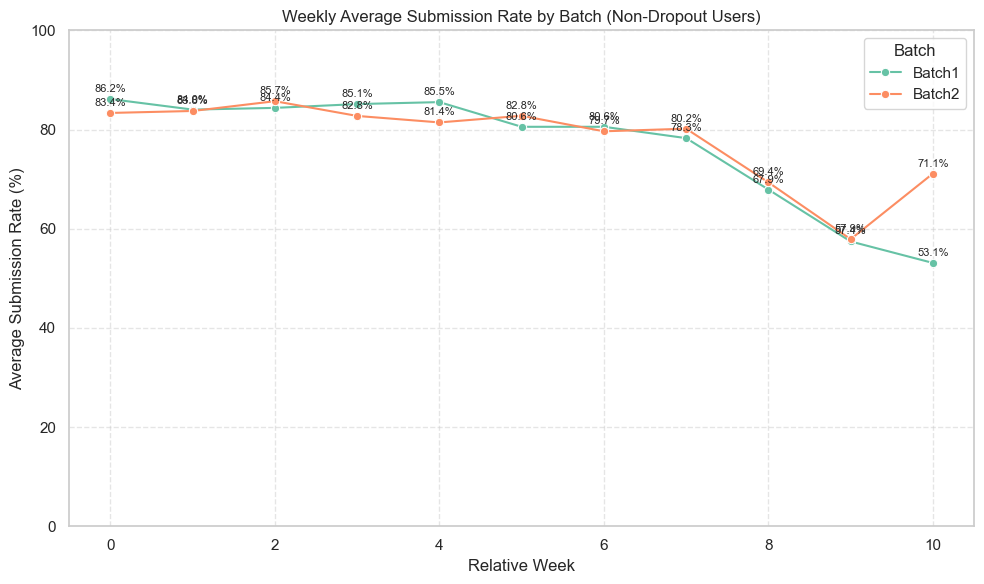

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ─── 설정 ───────────────────────────────────────────────────────────────
BASE_PATH = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
SENSOR_FOLDER = "source_12"
SENSOR_FILE = "data_source_12.csv"
EXPECTED_SAMPLES_PER_WEEK = (7 * 24 * 60) // 5  # = 2016
sns.set(style="whitegrid")

# Dropout 사용자 ID 리스트
batch1_ids = [542, 584, 597, 601, 608, 613, 617, 618, 621, 631, 639, 645]
batch2_ids = [662, 663, 666, 669, 682, 683, 689, 701, 704, 716, 723, 725, 726, 727, 736, 746, 756, 765, 767, 769]
dropout_users = {f"cmp1_usr{uid}" for uid in batch1_ids + batch2_ids}

# ─── 비-드롭아웃 사용자 전용 주차별 샘플 수 및 제출률 계산 ─────────────────
def build_non_dropout_weekly_records():
    recs = []
    for batch in ["Batch1","Batch2"]:
        for user_folder in (BASE_PATH / batch).glob("cmp1_usr*"):
            uid = user_folder.name
            if uid in dropout_users:
                continue  # 드롭아웃 유저는 건너뜀

            csv_path = user_folder / SENSOR_FOLDER / SENSOR_FILE
            if not csv_path.exists():
                continue

            df = pd.read_csv(csv_path, usecols=["timestamp"])
            if df.empty:
                continue

            # 타임스탬프 파싱 + 중복 제거
            df["ts"] = pd.to_datetime(df["timestamp"], errors="coerce")
            df = df.dropna(subset=["ts"]).drop_duplicates(["ts"])
            if df.empty:
                continue

            # 상대 주차 계산
            start = df["ts"].min()
            df["week"] = ((df["ts"] - start).dt.days // 7).astype(int)

            # 5분 이내 중복 제거 함수
            def count_valid(xs):
                xs = xs.sort_values().reset_index(drop=True)
                last, cnt = xs.iloc[0], 1
                for x in xs.iloc[1:]:
                    if (x - last).total_seconds() >= 300:
                        cnt += 1
                        last = x
                return cnt

            weekly_counts = df.groupby("week")["ts"].apply(count_valid).to_dict()
            for wk, cnt in weekly_counts.items():
                recs.append({
                    "Batch": batch,
                    "Week": wk,
                    "SubmissionRate": cnt / EXPECTED_SAMPLES_PER_WEEK * 100
                })
    return pd.DataFrame(recs)

# ─── 실행 및 그룹 평균 계산 ───────────────────────────────────────────────
df_non = build_non_dropout_weekly_records()
avg_non = df_non.groupby(["Batch","Week"])["SubmissionRate"].mean().reset_index()
avg_non = avg_non[avg_non["Week"] <= 10]

# ─── 꺾은선 그래프 ────────────────────────────────────────────────────────
plt.figure(figsize=(10,6))
sns.lineplot(data=avg_non, x="Week", y="SubmissionRate", hue="Batch", marker="o", palette="Set2")

# 값 레이블 추가
for _, row in avg_non.iterrows():
    plt.text(row["Week"], row["SubmissionRate"]+1, f"{row['SubmissionRate']:.1f}%",
             ha="center", va="bottom", fontsize=8)

plt.title("Weekly Average Submission Rate by Batch (Non-Dropout Users)")
plt.xlabel("Relative Week")
plt.ylabel("Average Submission Rate (%)")
plt.ylim(0, 100)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Batch")
plt.tight_layout()
plt.show()

In [5]:
# 사용자별 평균 누락률 계산
user_missing = df.groupby(['Batch', 'User'])['Final Missing %'].mean().reset_index()

# ✅ 고누락 여부 컬럼 명시적으로 추가
user_missing['HighMissing'] = user_missing['Final Missing %'] >= 50
user_missing['UserID_NumOnly'] = user_missing['User'].astype(str).str.extract(r'(\d+)$')

# 🔹 통계 요약: 고누락 사용자 수 및 비율 계산
high_missing_stats = (
    user_missing.groupby('Batch')['HighMissing']
    .agg(['sum', 'count'])
    .rename(columns={'sum': 'Num_Users_50plus', 'count': 'Total_Users'})
)
high_missing_stats['Proportion (%)'] = (high_missing_stats['Num_Users_50plus'] / high_missing_stats['Total_Users']) * 100

# 🔹 결과 출력
print("✅ 고누락 사용자 비율 (누락률 ≥ 50% 기준):")
print(high_missing_stats)

# 🔹 Batch별 고누락 사용자 ID 출력
print("\n✅ 고누락 사용자 목록 (누락률 ≥ 50%):")
for batch in user_missing['Batch'].unique():
    user_cmp_ids = user_missing[(user_missing['Batch'] == batch) & (user_missing['HighMissing'])]['User'].tolist()
    print(f"🔸 {batch} ({len(user_cmp_ids)}명): {', '.join(user_cmp_ids)}")

for batch in user_missing['Batch'].unique():
    user_ids = user_missing[
        (user_missing['Batch'] == batch) & (user_missing['HighMissing'])
    ]['UserID_NumOnly'].dropna().tolist()
    print(user_ids)
    print(f"🔸 {batch} ({len(user_ids)}명): {', '.join(user_ids)}")

✅ 고누락 사용자 비율 (누락률 ≥ 50% 기준):
        Num_Users_50plus  Total_Users  Proportion (%)
Batch                                                
Batch1                18           66       27.272727
Batch2                31          109       28.440367

✅ 고누락 사용자 목록 (누락률 ≥ 50%):
🔸 Batch1 (18명): cmp1_usr542, cmp1_usr584, cmp1_usr588, cmp1_usr590, cmp1_usr596, cmp1_usr597, cmp1_usr601, cmp1_usr608, cmp1_usr613, cmp1_usr616, cmp1_usr617, cmp1_usr618, cmp1_usr621, cmp1_usr631, cmp1_usr639, cmp1_usr645, cmp1_usr646, cmp1_usr652
🔸 Batch2 (31명): cmp1_usr660, cmp1_usr662, cmp1_usr663, cmp1_usr666, cmp1_usr669, cmp1_usr678, cmp1_usr682, cmp1_usr683, cmp1_usr685, cmp1_usr686, cmp1_usr689, cmp1_usr690, cmp1_usr701, cmp1_usr704, cmp1_usr705, cmp1_usr712, cmp1_usr716, cmp1_usr717, cmp1_usr723, cmp1_usr725, cmp1_usr726, cmp1_usr727, cmp1_usr731, cmp1_usr736, cmp1_usr746, cmp1_usr750, cmp1_usr756, cmp1_usr764, cmp1_usr765, cmp1_usr767, cmp1_usr769
['542', '584', '588', '590', '596', '597', '601', '608', '613

### Dropout Analysis

In [17]:
# 🔹 고누락 사용자 숫자 ID 리스트

batch1_nums = [542, 584, 597, 601, 608, 613, 617, 618, 621, 631, 639, 645]
batch2_nums = [662,663,666,669,682,683,689,701,704,716,723,725,726,727,736,746,756,765,767,769]

# 🔹 사용자 ID 문자열로 변환
batch1_ids = [f"cmp1_usr{uid}" for uid in batch1_nums]
batch2_ids = [f"cmp1_usr{uid}" for uid in batch2_nums]

# 🔹 DataFrame에서 사용자별 필터링
df_batch1 = df[df['User'].isin(batch1_ids)].copy()
df_batch2 = df[df['User'].isin(batch2_ids)].copy()

start_map1 = df_batch1.groupby('User')['StartDate'].min().apply(pd.to_datetime).to_dict()
start_map2 = df_batch2.groupby('User')['StartDate'].min().apply(pd.to_datetime).to_dict()

# 🔹 사용자별 EndDate 기준 상대 주차 계산
df_batch1['DropWeek'] = df_batch1.apply(
    lambda row: (pd.to_datetime(row['EndDate']) - start_map1[row['User']]).days // 7
    if pd.notnull(row['EndDate']) else None,
    axis=1
)
df_batch2['DropWeek'] = df_batch2.apply(
    lambda row: (pd.to_datetime(row['EndDate']) - start_map2[row['User']]).days // 7
    if pd.notnull(row['EndDate']) else None,
    axis=1
)

# 🔹 사용자별 마지막 주차만 추출
drop_weeks_1 = df_batch1.groupby('User')['DropWeek'].max().reset_index()
drop_weeks_1['Batch'] = 'Batch1'

drop_weeks_2 = df_batch2.groupby('User')['DropWeek'].max().reset_index()
drop_weeks_2['Batch'] = 'Batch2'

# 🔹 병합
drop_weeks_all = pd.concat([drop_weeks_1, drop_weeks_2], ignore_index=True)

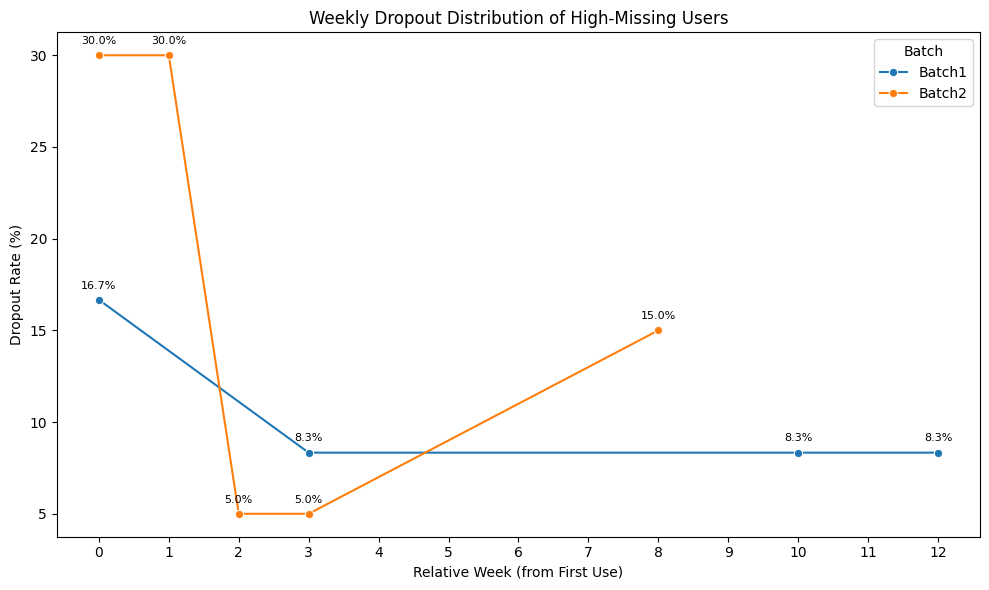

In [18]:
drop_counts = drop_weeks_all.groupby(['Batch', 'DropWeek'])['User'].count().reset_index(name='UserCount')

# 🔹 Calculate proportion within each batch
batch_totals = drop_weeks_all.groupby('Batch')['User'].nunique().to_dict()
drop_counts['Proportion (%)'] = drop_counts.apply(
    lambda row: (row['UserCount'] / batch_totals[row['Batch']]) * 100, axis=1
)

# 🔹 Visualization: line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=drop_counts, x='DropWeek', y='Proportion (%)', hue='Batch', marker='o')

# 🔹 Annotate each point with percentage
for i in range(len(drop_counts)):
    row = drop_counts.iloc[i]
    plt.text(row['DropWeek'], row['Proportion (%)'] + 0.5, f"{row['Proportion (%)']:.1f}%", 
             ha='center', va='bottom', fontsize=8, color='black')

# 🔹 English labels and layout
plt.title("Weekly Dropout Distribution of High-Missing Users")
plt.xlabel("Relative Week (from First Use)")
plt.ylabel("Dropout Rate (%)")
plt.xticks(range(int(drop_weeks_all['DropWeek'].min()), int(drop_weeks_all['DropWeek'].max()) + 1))
plt.legend(title='Batch')
plt.tight_layout()
plt.show()

▶ Dropout Users' Weeks with Data (by Batch):
        count  mean   std  min  median  max
Batch                                      
Batch1     12  1.42  2.23    0     0.0    6
Batch2     20  1.90  1.45    0     2.0    5


/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/4124144126.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/4124144126.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


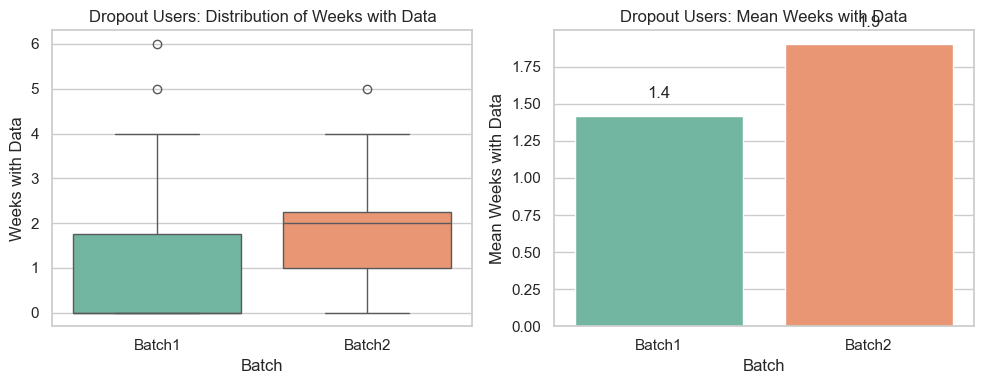

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ─── (0) Dropout 사용자 ID 정의 ─────────────────────────────────────────────
batch1_nums = [542,584,597,601,608,613,617,618,621,631,639,645]
batch2_nums = [662,663,666,669,682,683,689,701,704,716,723,725,726,727,736,746,756,765,767,769]
dropout_ids = {f"cmp1_usr{u}" for u in batch1_nums + batch2_nums}

# ─── (1) 앞서 만든 user_week_map 재사용 ────────────────────────────────────
# user_week_map = build_weekly_sample_map()  # 이미 만들어진 dict이라고 가정

# ─── (2) Dropout 사용자만 필터링해서 주차 개수 계산 ────────────────────────
records = []
for uid, weeks in user_week_map.items():
    if uid not in dropout_ids:
        continue
    batch = "Batch1" if int(uid.replace("cmp1_usr","")) < 660 else "Batch2"
    # 실제 데이터가 있는 주차 수
    num_weeks = len([w for w,c in weeks.items() if c > 0])
    records.append({"User": uid, "Batch": batch, "WeeksWithData": num_weeks})

df_dropout_weeks = pd.DataFrame(records)

# ─── (3) 배치별 평균·표준편차 계산 ────────────────────────────────────────
stats = (
    df_dropout_weeks
    .groupby("Batch")["WeeksWithData"]
    .agg(["count","mean","std","min","median","max"])
    .round(2)
)
print("▶ Dropout Users' Weeks with Data (by Batch):")
print(stats)

# ─── (4) 시각화: 박스플롯 / 바플롯 ────────────────────────────────────────
sns.set(style="whitegrid")
fig, axes = plt.subplots(1,2,figsize=(10,4))

# 4-1) 박스플롯
sns.boxplot(
    data=df_dropout_weeks,
    x="Batch", y="WeeksWithData",
    palette=["#66C2A5","#FC8D62"],
    ax=axes[0]
)
axes[0].set_title("Dropout Users: Distribution of Weeks with Data")
axes[0].set_ylabel("Weeks with Data")

# 4-2) 바플롯 (평균)
mean_vals = df_dropout_weeks.groupby("Batch")["WeeksWithData"].mean().reset_index()
sns.barplot(
    data=mean_vals,
    x="Batch", y="WeeksWithData",
    palette=["#66C2A5","#FC8D62"],
    ax=axes[1]
)
for i,row in mean_vals.iterrows():
    axes[1].text(i, row["WeeksWithData"]+0.1, f"{row['WeeksWithData']:.1f}", 
                 ha="center", va="bottom")
axes[1].set_title("Dropout Users: Mean Weeks with Data")
axes[1].set_ylabel("Mean Weeks with Data")

plt.tight_layout()
plt.show()

#### Dropout users 중 Early/Late 구분

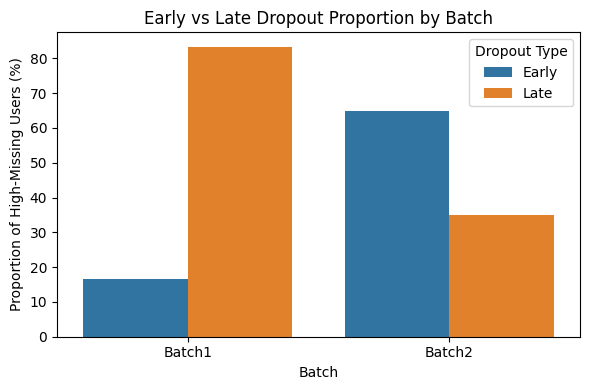

,Batch,Count_Early,Count_Late,Proportion_Early (%),Proportion_Late (%)
0,Batch1,2.0,10.0,16.7,83.3
1,Batch2,13.0,7.0,65.0,35.0


In [19]:
# 이탈 유형 분류
drop_weeks_all['DropoutType'] = drop_weeks_all['DropWeek'].apply(
    lambda x: 'Early' if x <= 2 else 'Late'
)

# Batch별 이탈 유형 비율 계산
dropout_type_counts = (
    drop_weeks_all.groupby(['Batch', 'DropoutType'])['User']
    .count()
    .reset_index(name='Count')
)

# 비율 추가
total_per_batch = dropout_type_counts.groupby('Batch')['Count'].transform('sum')
dropout_type_counts['Proportion (%)'] = (dropout_type_counts['Count'] / total_per_batch) * 100

# 시각화 (막대그래프)
plt.figure(figsize=(6, 4))
sns.barplot(data=dropout_type_counts, x='Batch', y='Proportion (%)', hue='DropoutType')
plt.title("Early vs Late Dropout Proportion by Batch")
plt.ylabel("Proportion of High-Missing Users (%)")
plt.xlabel("Batch")
plt.legend(title="Dropout Type")
plt.tight_layout()
plt.show()

# 🔹 전체 대비 비율 계산
dropout_type_counts['Total'] = dropout_type_counts.groupby('Batch')['Count'].transform('sum')
dropout_type_counts['Proportion (%)'] = (dropout_type_counts['Count'] / dropout_type_counts['Total']) * 100

# 🔹 표 형태 출력
dropout_table = dropout_type_counts.pivot(index='Batch', columns='DropoutType', values=['Count', 'Proportion (%)'])
dropout_table = dropout_table.round(1)  # 소수점 반올림

# 보기 좋게 컬럼 정리
dropout_table.columns = ['Count_Early', 'Count_Late', 'Proportion_Early (%)', 'Proportion_Late (%)']
dropout_table = dropout_table.reset_index()

# ✅ 표 출력
import IPython.display as disp
disp.display(dropout_table)

##### High missing rate users' data collection per week_Heatmap

/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/4250794296.py:47: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  columns=all_weeks).fillna(0)


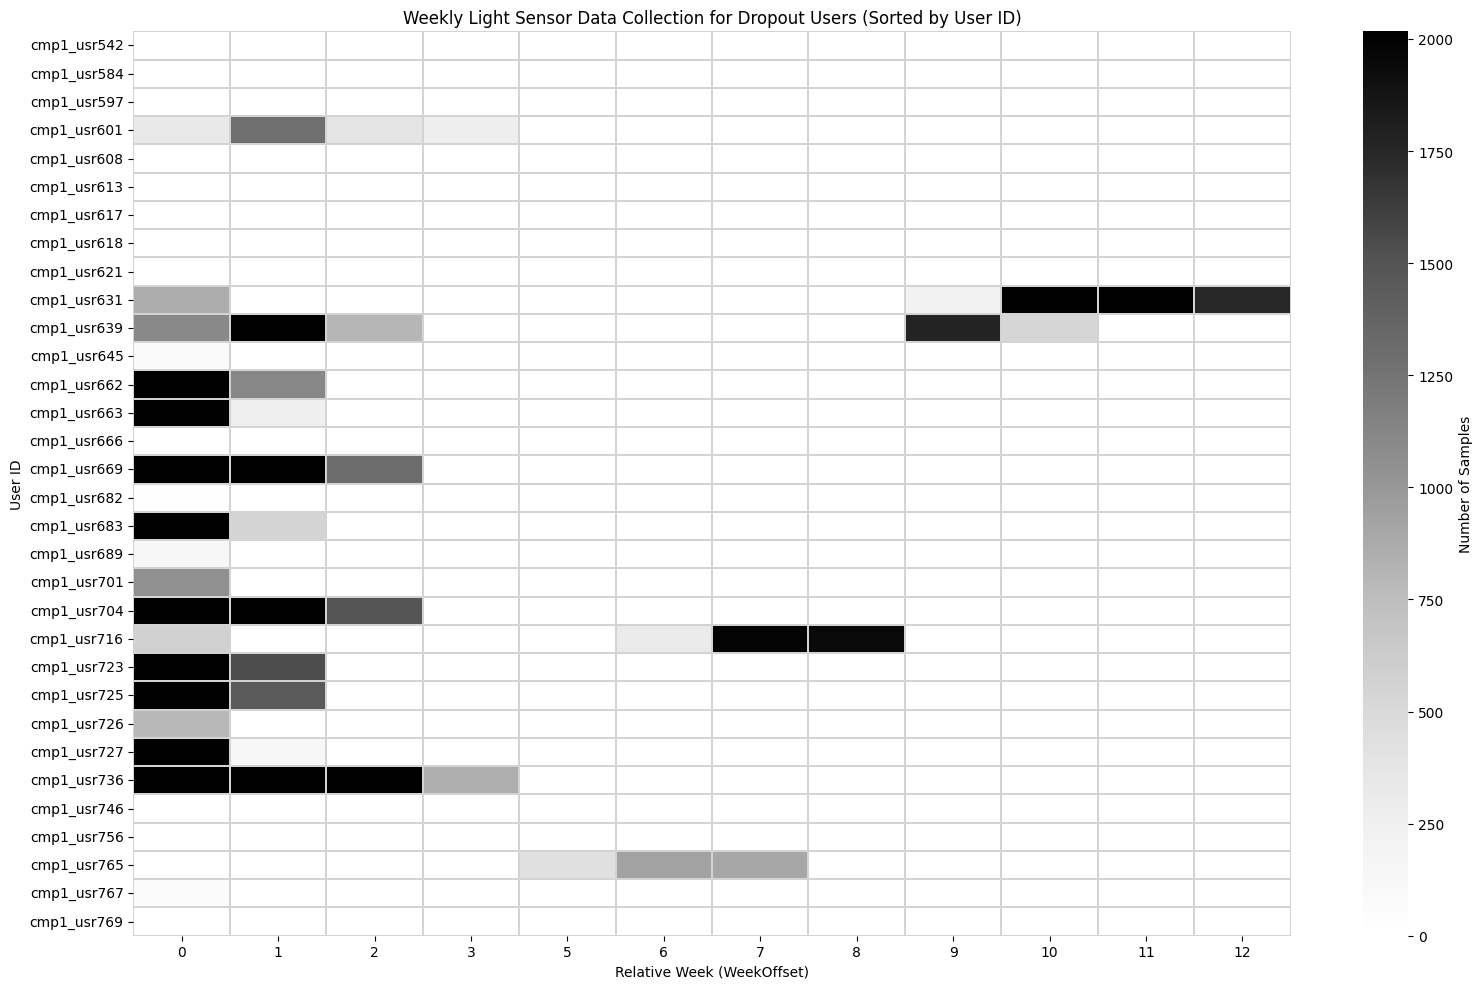

In [20]:
# 🔹 고누락자 ID 리스트 (batch별)
batch1_ids = [542, 584, 597, 601, 608, 613, 617, 618, 621, 631, 639, 645]
batch2_ids = [662,663,666,669,682,683,689,701,704,716,723,725,726,727,736,746,756,765,767,769]

BASE_PATH = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
SENSOR_FOLDER = "source_12"
SENSOR_FILE = "data_source_12.csv"

user_week_data = {}

# 🔁 각 사용자별 주차별 샘플 수 계산
for batch, user_ids in [("Batch1", batch1_ids), ("Batch2", batch2_ids)]:
    for uid in user_ids:
        user_id = f"cmp1_usr{uid}"
        file_path = BASE_PATH / batch / user_id / SENSOR_FOLDER / SENSOR_FILE
        
        if not file_path.exists():
            user_week_data[user_id] = {}  # 비어 있는 사용자도 포함
            continue
        
        try:
            df = pd.read_csv(file_path)
            if df.empty or 'timestamp' not in df.columns:
                user_week_data[user_id] = {}
                continue
            
            timestamps = pd.to_datetime(df['timestamp'], errors='coerce').dropna()
            if timestamps.empty:
                user_week_data[user_id] = {}
                continue

            # 상대 주차 계산
            start_time = timestamps.min()
            week_offsets = ((timestamps - start_time).dt.days // 7).astype(int)
            week_counts = week_offsets.value_counts().to_dict()
            user_week_data[user_id] = week_counts

        except Exception as e:
            print(f"❌ Error processing {user_id}: {e}")
            user_week_data[user_id] = {}

# 🔹 유니크한 전체 주차 범위
all_weeks = sorted(set(week for counts in user_week_data.values() for week in counts.keys()))

# 🔹 히트맵 데이터프레임 구성
heatmap_df = pd.DataFrame(index=sorted(user_week_data.keys(), key=lambda x: int(x.split('usr')[-1])),
                          columns=all_weeks).fillna(0)

for user, week_counts in user_week_data.items():
    for week, count in week_counts.items():
        heatmap_df.loc[user, week] = count

# 🔹 시각화
plt.figure(figsize=(16, max(10, 0.25 * len(heatmap_df))))
sns.heatmap(
    heatmap_df.astype(float),
    cmap="Greys",
    linewidths=0.3,
    linecolor="lightgray",
    cbar_kws={"label": "Number of Samples"}
)

plt.title("Weekly Light Sensor Data Collection for Dropout Users (Sorted by User ID)")
plt.xlabel("Relative Week (WeekOffset)")
plt.ylabel("User ID")
plt.tight_layout()
plt.show()

/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/1015922018.py:59: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = pd.DataFrame(index=sorted_user_ids(user_map.keys()), columns=all_weeks).fillna(0)
/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/1015922018.py:59: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = pd.DataFrame(index=sorted_user_ids(user_map.keys()), columns=all_weeks).fillna(0)
/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/1015922018.py:91: UserWarning: Glyph 128202 (\N{BAR CHART}) mis

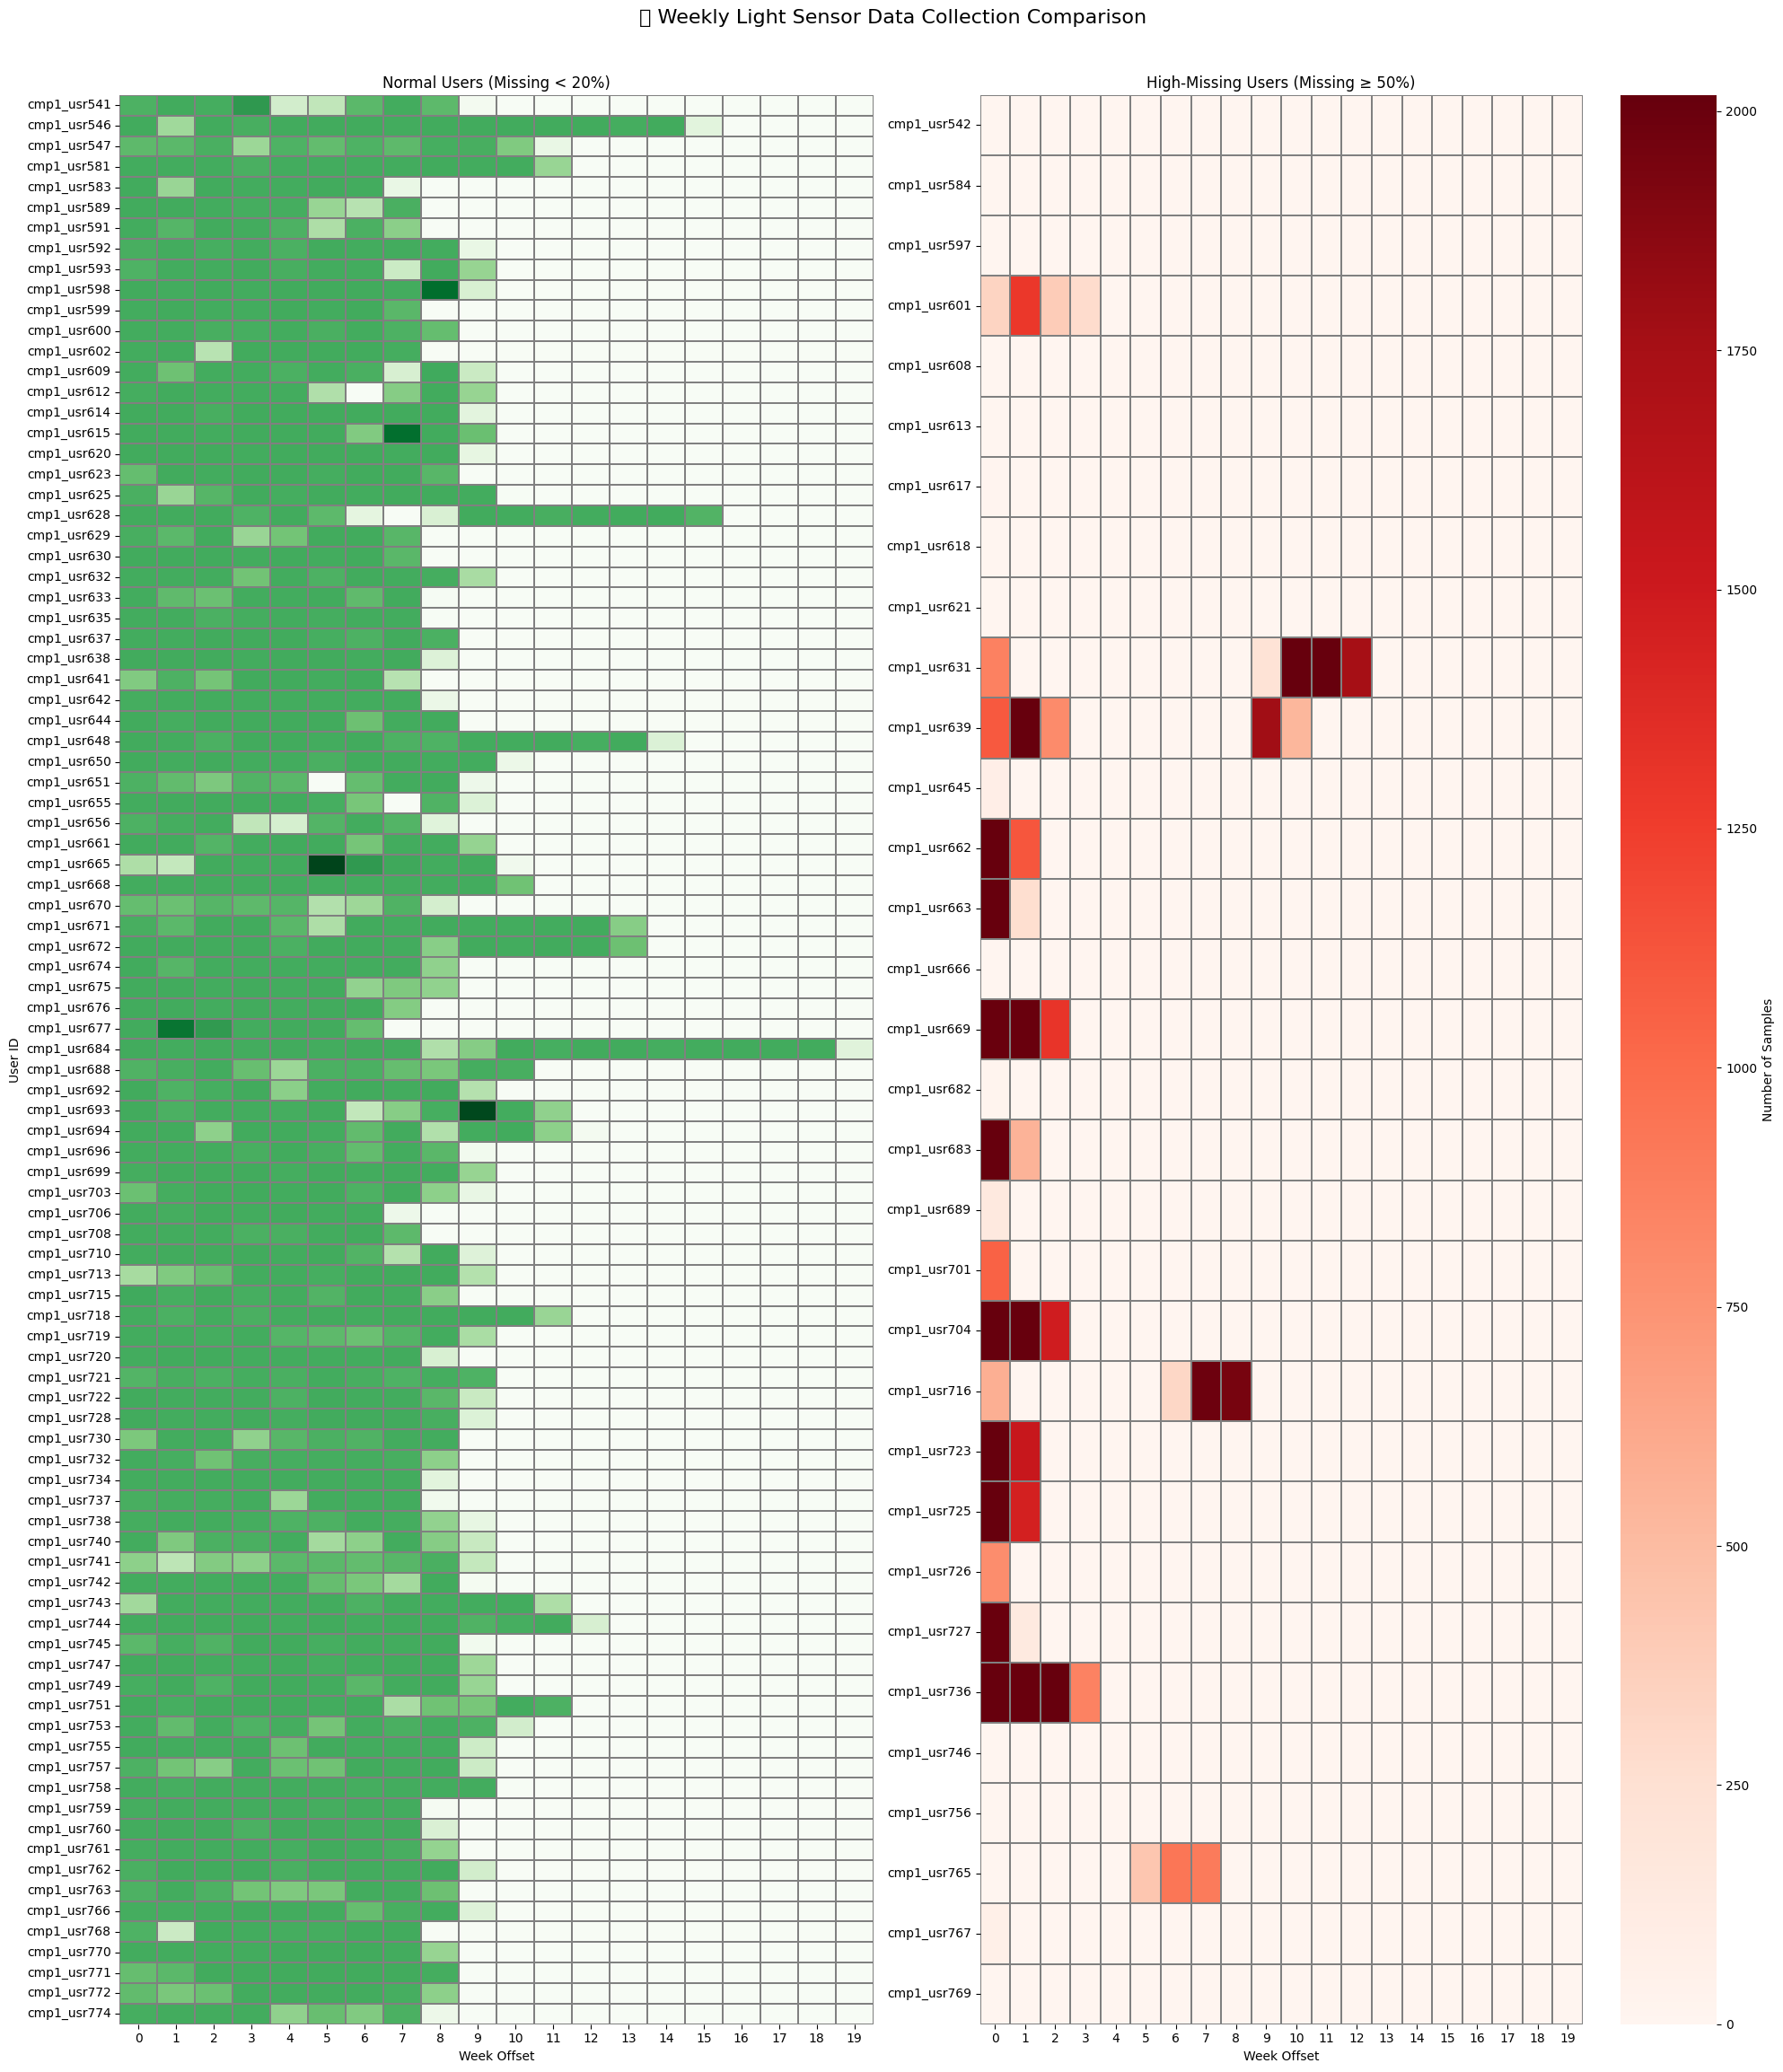

In [21]:
# 🔹 센서 설정
BASE_PATH = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
SENSOR_FOLDER = "source_12"
SENSOR_FILE = "data_source_12.csv"

# 🔹 고누락자 ID (숫자 형태)
batch1_ids = [542, 584, 597, 601, 608, 613, 617, 618, 621, 631, 639, 645]
batch2_ids = [662,663,666,669,682,683,689,701,704,716,723,725,726,727,736,746,756,765,767,769]

high_user_ids = [f"cmp1_usr{uid}" for uid in batch1_ids + batch2_ids]

# 🔹 데이터 불러오기 및 전처리
df = pd.read_csv("final_corrected_missing_summary.csv")
df['StartDate'] = pd.to_datetime(df['StartDate'])
df = df[df['Source'] != 'Permission']  # Permission 제외

# 🔹 평균 누락률 계산 → 정상 사용자 추출 (Light 기준)
user_missing = df[df['Source'] == 'Light'].groupby(['User', 'Batch'])['Final Missing %'].mean().reset_index()
normal_df = user_missing[user_missing['Final Missing %'] < 20]
normal_users = normal_df['User'].tolist()

# 🔹 사용자 → 배치 매핑 생성
normal_batch_map = dict(zip(normal_df['User'], normal_df['Batch']))
high_batch_map = {f"cmp1_usr{uid}": "Batch1" for uid in batch1_ids}
high_batch_map.update({f"cmp1_usr{uid}": "Batch2" for uid in batch2_ids})

# 🔹 주차별 샘플 수 계산 함수
def get_weekly_sample_map(user_batch_map):
    user_map = {}
    for user_id, batch in user_batch_map.items():
        file_path = BASE_PATH / batch / user_id / SENSOR_FOLDER / SENSOR_FILE
        if not file_path.exists():
            user_map[user_id] = {}
            continue
        try:
            df = pd.read_csv(file_path)
            if df.empty or 'timestamp' not in df.columns:
                user_map[user_id] = {}
                continue
            timestamps = pd.to_datetime(df['timestamp'], errors='coerce').dropna()
            if timestamps.empty:
                user_map[user_id] = {}
                continue
            start = timestamps.min()
            week_offset = ((timestamps - start).dt.days // 7).astype(int)
            count_map = week_offset.value_counts().to_dict()
            user_map[user_id] = count_map
        except Exception as e:
            print(f"❌ Error: {user_id} → {e}")
            user_map[user_id] = {}
    return user_map

# 🔹 정렬 함수
def sorted_user_ids(user_list):
    return sorted(user_list, key=lambda x: int(x.split('usr')[-1]))

# 🔹 히트맵 DF 생성 함수
def to_heatmap_df(user_map, all_weeks):
    df = pd.DataFrame(index=sorted_user_ids(user_map.keys()), columns=all_weeks).fillna(0)
    for user, week_counts in user_map.items():
        for week, count in week_counts.items():
            df.loc[user, week] = count
    return df.astype(float)

# 🔹 데이터 수집
normal_map = get_weekly_sample_map(normal_batch_map)
high_map = get_weekly_sample_map(high_batch_map)

# 🔹 전체 주차 목록
all_weeks = sorted(set(week for d in list(normal_map.values()) + list(high_map.values()) for week in d))

# 🔹 히트맵용 DataFrame
heat_normal = to_heatmap_df(normal_map, all_weeks)
heat_high = to_heatmap_df(high_map, all_weeks)

# 🔹 히트맵 시각화
fig, axes = plt.subplots(1, 2, figsize=(20, max(10, 0.25 * max(len(heat_normal), len(heat_high)))), sharey=False)

sns.heatmap(heat_normal, cmap="Greens", ax=axes[0], cbar=False,
            linewidths=0.2, linecolor="gray")
axes[0].set_title("Normal Users (Missing < 20%)")
axes[0].set_xlabel("Week Offset")
axes[0].set_ylabel("User ID")

sns.heatmap(heat_high, cmap="Reds", ax=axes[1], cbar_kws={"label": "Number of Samples"},
            linewidths=0.2, linecolor="gray")
axes[1].set_title("High-Missing Users (Missing ≥ 50%)")
axes[1].set_xlabel("Week Offset")

plt.suptitle("📊 Weekly Light Sensor Data Collection Comparison", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [8]:
!pip install openpyxl

/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/2435974249.py:78: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heatmap_df = pd.DataFrame(index=user_ids_sorted, columns=all_weeks).fillna(0)
/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/2435974249.py:83: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '63.9' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  heatmap_df.loc[user_id, week] = round(ratio * 100, 1)  # 비율(%)로 저장
/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/2435974249.py:83: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pa

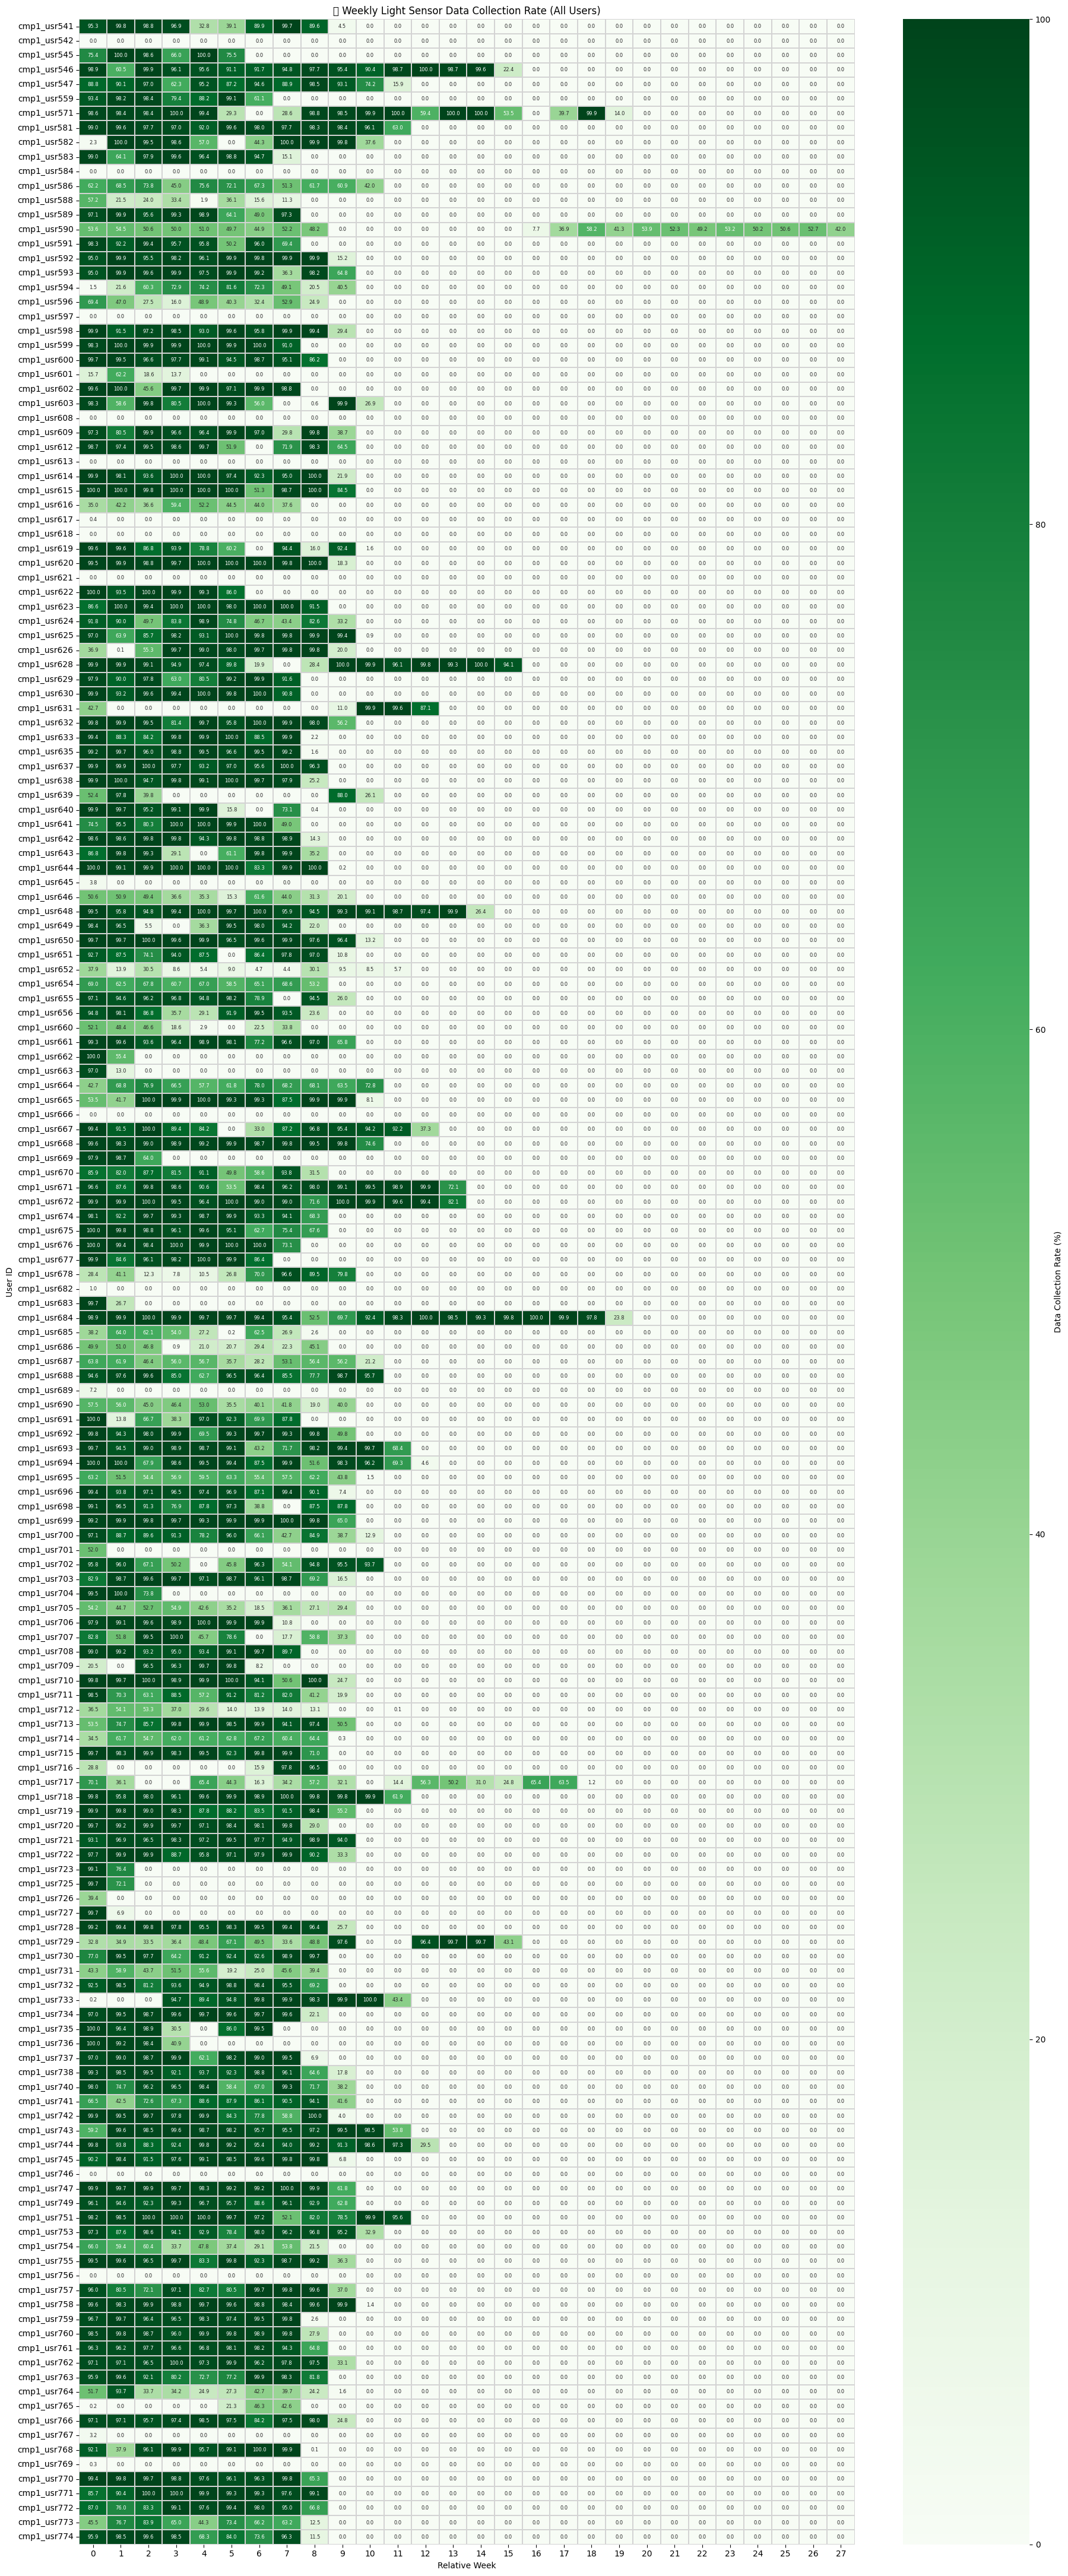

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 기본 설정
BASE_PATH = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
SENSOR_FOLDER = "source_12"
SENSOR_FILE = "data_source_12.csv"
BATCHES = ["Batch1", "Batch2"]
EXPECTED_SAMPLES_PER_WEEK = (7 * 24 * 60) // 5  # = 2016
OUTPUT_PATH = Path("./analysis_outputs")
OUTPUT_PATH.mkdir(exist_ok=True, parents=True)

MIN_INTERVAL_SECONDS = 300  # 5분

# 🔹 사용자별 주차별 샘플 수 계산 함수
def get_all_users_weekly_sample_count():
    user_week_map = {}
    for batch in BATCHES:
        batch_path = BASE_PATH / batch
        if not batch_path.exists():
            continue

        for user_folder in batch_path.iterdir():
            if not user_folder.is_dir():
                continue

            user_id = user_folder.name
            file_path = user_folder / SENSOR_FOLDER / SENSOR_FILE

            if not file_path.exists():
                user_week_map[user_id] = {}
                continue

            try:
                df = pd.read_csv(file_path)
                if df.empty or 'timestamp' not in df.columns:
                    user_week_map[user_id] = {}
                    continue

                unique_timestamps = pd.to_datetime(df['timestamp'], errors='coerce').dropna().drop_duplicates()
                if unique_timestamps.empty:
                    user_week_map[user_id] = {}
                    continue

                start_time = unique_timestamps.min()
                week_offsets = ((unique_timestamps - start_time).dt.days // 7).astype(int)
                df_valid = pd.DataFrame({'timestamp': unique_timestamps, 'week': week_offsets})

                def count_valid_samples(ts_series):
                    ts_sorted = ts_series.sort_values().reset_index(drop=True)
                    filtered = [ts_sorted.iloc[0]]
                    for ts in ts_sorted.iloc[1:]:
                        if (ts - filtered[-1]).total_seconds() >= 300:
                            filtered.append(ts)
                    return len(filtered)
                
                #counts = week_offsets.value_counts().to_dict()
                #user_week_map[user_id] = counts
                valid_counts = df_valid.groupby('week')['timestamp'].apply(count_valid_samples).to_dict()
                user_week_map[user_id] = valid_counts

            except Exception as e:
                print(f"❌ Error reading {file_path}: {e}")
                user_week_map[user_id] = {}

    return user_week_map

# 🔹 데이터 수집
weekly_sample_map = get_all_users_weekly_sample_count()

# 🔹 전체 주차 목록과 사용자 정렬
all_weeks = sorted({week for weeks in weekly_sample_map.values() for week in weeks})
user_ids_sorted = sorted(weekly_sample_map.keys(), key=lambda x: int(x.split('usr')[-1]))

# 🔹 비율 (%) 계산용 히트맵 데이터프레임
heatmap_df = pd.DataFrame(index=user_ids_sorted, columns=all_weeks).fillna(0)

for user_id, week_counts in weekly_sample_map.items():
    for week, count in week_counts.items():
        ratio = count / EXPECTED_SAMPLES_PER_WEEK
        heatmap_df.loc[user_id, week] = round(ratio * 100, 1)  # 비율(%)로 저장

# 🔹 히트맵 시각화
plt.figure(figsize=(18, max(10, 0.25 * len(heatmap_df))))
ax = sns.heatmap(
    heatmap_df.astype(float),
    cmap="Greens",
    linewidths=0.3,
    linecolor="lightgray",
    cbar_kws={"label": "Data Collection Rate (%)"},
    annot=heatmap_df.astype(float),
    fmt=".1f",
    annot_kws={"size": 6}
)

plt.title("📊 Weekly Light Sensor Data Collection Rate (All Users)")
plt.xlabel("Relative Week")
plt.ylabel("User ID")
plt.tight_layout()
plt.savefig(OUTPUT_PATH / "heatmap_sensor_collection_rate_with_percent.png")
plt.show()

# 🔹 엑셀로 저장
#heatmap_df.to_excel(OUTPUT_PATH / "weekly_sensor_collection_rate_percent2.xlsx")

#### Dropout users

/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/2697977320.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_all, x="batch", y="dropout_week", palette="pastel")


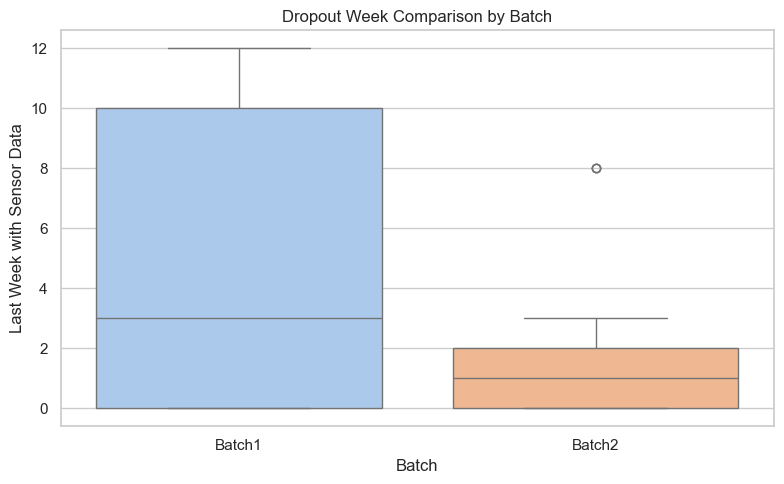

/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/2697977320.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_all, x="batch", y="dropout_missing_rate", palette="Set2")


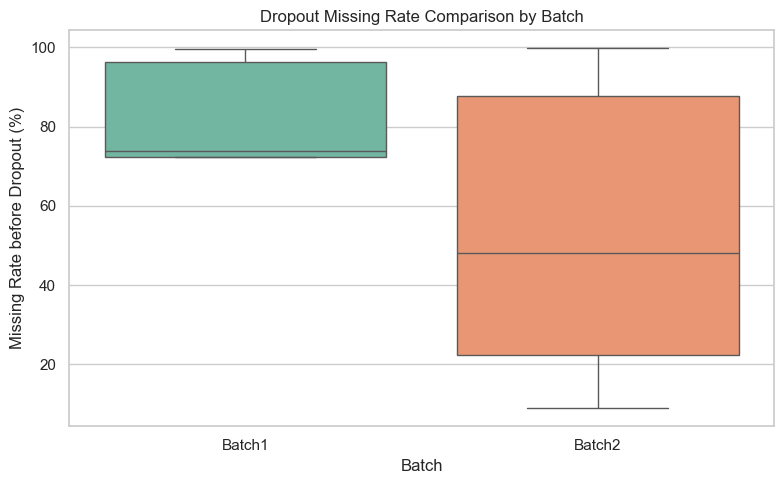

📋 Dropout Summary Table by Batch (Missing Rate):
        dropout_week_count  dropout_week_mean  dropout_week_std  \
batch                                                             
Batch1                   5               5.00              5.66   
Batch2                  17               2.06              2.95   

        dropout_week_min  dropout_week_median  dropout_week_max  \
batch                                                             
Batch1                 0                  3.0                12   
Batch2                 0                  1.0                 8   

        missing_rate_count  missing_rate_mean  missing_rate_std  \
batch                                                             
Batch1                   5              82.88             13.77   
Batch2                  17              54.75             33.18   

        missing_rate_min  missing_rate_median  missing_rate_max  
batch                                                            
Batch1      

In [158]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ─── 설정 ───────────────────────────────────────────────────────────────
BASE_PATH = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
EXPECTED_SAMPLES_PER_WEEK = (7 * 24 * 60) // 5  # 2016
sns.set(style="whitegrid")
OUTPUT_PATH = Path("./analysis_outputs")
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

# Dropout 사용자 ID 리스트 (문자열)
batch1_ids = [f"cmp1_usr{uid}" for uid in [542,584,597,601,608,613,617,618,621,631,639,645]]
batch2_ids = [f"cmp1_usr{uid}" for uid in [662,663,666,669,682,683,689,701,704,716,723,725,
                                          726,727,736,746,756,765,767,769]]
dropout_users = batch1_ids + batch2_ids

# ─── Dropout 통계 수집 함수(누락률 계산) ─────────────────────────────────
def get_dropout_stats(user_ids, weekly_map):
    recs = []
    for uid in user_ids:
        if uid not in weekly_map: 
            continue
        wmap = weekly_map[uid]
        if not wmap:
            continue

        last_week = max(wmap.keys())
        total_collected = sum(cnt for wk, cnt in wmap.items() if wk <= last_week)
        expected_total = (last_week + 1) * EXPECTED_SAMPLES_PER_WEEK

        # submission_rate = total_collected / expected_total
        missing_rate = 1 - (total_collected / expected_total) if expected_total>0 else 0

        recs.append({
            "user_id": uid,
            "dropout_week": last_week,
            "dropout_missing_rate": missing_rate * 100  # % 단위
        })
    return pd.DataFrame(recs)

# ─── 통계 계산 ───────────────────────────────────────────────────────────
df1 = get_dropout_stats(batch1_ids, weekly_sample_map)
df1["batch"] = "Batch1"
df2 = get_dropout_stats(batch2_ids, weekly_sample_map)
df2["batch"] = "Batch2"

df_all = pd.concat([df1, df2], ignore_index=True)

# ─── 시각화 1: 이탈 주차 비교 ───────────────────────────────────────────
plt.figure(figsize=(8,5))
sns.boxplot(data=df_all, x="batch", y="dropout_week", palette="pastel")
plt.title("Dropout Week Comparison by Batch")
plt.ylabel("Last Week with Sensor Data")
plt.xlabel("Batch")
plt.tight_layout()
plt.savefig(OUTPUT_PATH/"dropout_week_comparison.png")
plt.show()

# ─── 시각화 2: 이탈 전 누락률 비교 ───────────────────────────────────────
plt.figure(figsize=(8,5))
sns.boxplot(data=df_all, x="batch", y="dropout_missing_rate", palette="Set2")
plt.title("Dropout Missing Rate Comparison by Batch")
plt.ylabel("Missing Rate before Dropout (%)")
plt.xlabel("Batch")
plt.tight_layout()
plt.savefig(OUTPUT_PATH/"dropout_missing_rate_comparison.png")
plt.show()

# ─── 배치별 요약 통계표 생성 ─────────────────────────────────────────────
summary = (
    df_all
    .groupby("batch")
    .agg(
        dropout_week_count=("dropout_week","count"),
        dropout_week_mean=("dropout_week","mean"),
        dropout_week_std=("dropout_week","std"),
        dropout_week_min=("dropout_week","min"),
        dropout_week_median=("dropout_week","median"),
        dropout_week_max=("dropout_week","max"),
        missing_rate_count=("dropout_missing_rate","count"),
        missing_rate_mean=("dropout_missing_rate","mean"),
        missing_rate_std=("dropout_missing_rate","std"),
        missing_rate_min=("dropout_missing_rate","min"),
        missing_rate_median=("dropout_missing_rate","median"),
        missing_rate_max=("dropout_missing_rate","max")
    )
    .round(2)
)

print("📋 Dropout Summary Table by Batch (Missing Rate):")
print(summary)

# 저장
#summary.to_excel(OUTPUT_PATH/"dropout_summary_missing_rate_by_batch.xlsx")

### 생존 분석 (Survival Analysis)

In [38]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 2.3 MB/s eta 0:00:0000:0100:01
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=f47da8ca683467d7420070c869b0e068f7fc869ab757c566851af33c43fe351a
  Stored in directory: /Users/yooseohyeon/Library/Caches/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


✅ weekly_sample_map.pkl 저장 완료


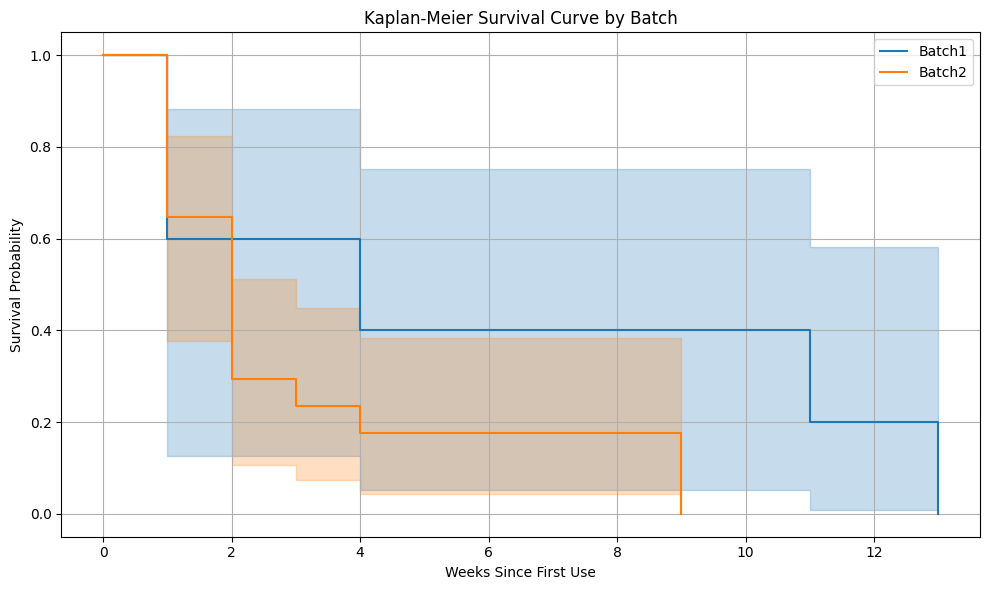

In [40]:
from lifelines import KaplanMeierFitter
import pickle

# 설정
EXPECTED_SAMPLES_PER_WEEK = (7 * 24 * 60) // 5  # 2016
BATCHES = ["Batch1", "Batch2"]
dropout_user_ids_batch1 = [f"cmp1_usr{uid}" for uid in [542, 584, 597, 601, 608, 613, 617, 618, 621, 631, 639, 645]]
dropout_user_ids_batch2 = [f"cmp1_usr{uid}" for uid in [662,663,666,669,682,683,689,701,704,716,723,725,726,727,736,746,756,765,767,769]]
all_dropout_ids = dropout_user_ids_batch1 + dropout_user_ids_batch2
batch_map = {uid: "Batch1" for uid in dropout_user_ids_batch1}
batch_map.update({uid: "Batch2" for uid in dropout_user_ids_batch2})

# 🔹 생존 분석 데이터 준비
def prepare_survival_data(weekly_sample_map, dropout_ids):
    durations, events, batches, valid_ids = [], [], [], []
    for user_id in dropout_ids:
        week_data = weekly_sample_map.get(user_id, {})
        if not week_data:
            continue
        sorted_weeks = sorted(week_data.items())
        duration = 0
        for week, count in sorted_weeks:
            if count == 0:
                break
            duration = week + 1
        durations.append(duration)
        events.append(1)  # dropout occurred
        batches.append(batch_map[user_id])
        valid_ids.append(user_id)

    return pd.DataFrame({
        "user_id": valid_ids,
        "duration": durations,
        "event": events,
        "batch": batches
    })

# 기존의 weekly_sample_map 생성 코드 사용 (이미 작성하셨던 함수)
weekly_sample_map = get_all_users_weekly_sample_count()

# 🔹 저장
with open(OUTPUT_PATH / "weekly_sample_map.pkl", "wb") as f:
    pickle.dump(weekly_sample_map, f)

print("✅ weekly_sample_map.pkl 저장 완료")
# 🔹 Load weekly_sample_map
#weekly_sample_map = pickle.load(open("./analysis_outputs/weekly_sample_map.pkl", "rb"))

# 🔹 데이터프레임 생성
survival_df = prepare_survival_data(weekly_sample_map, all_dropout_ids)

# 🔹 Kaplan-Meier Plot
plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

for batch in survival_df['batch'].unique():
    batch_df = survival_df[survival_df['batch'] == batch]
    kmf.fit(durations=batch_df["duration"], event_observed=batch_df["event"], label=batch)
    kmf.plot_survival_function()

plt.title("Kaplan-Meier Survival Curve by Batch")
plt.xlabel("Weeks Since First Use")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.tight_layout()
plt.show()

📊 Survival Data Summary:
        count      mean       std  min   25%   50%    75%   max
batch                                                          
Batch1   62.0  9.887097  3.711324  1.0  8.25  10.0  10.75  28.0
Batch2  102.0  9.058824  3.514675  1.0  9.00  10.0  10.00  20.0

📊 Batch별 사용자 수 및 dropout 비율:
event     1
batch      
Batch1  1.0
Batch2  1.0


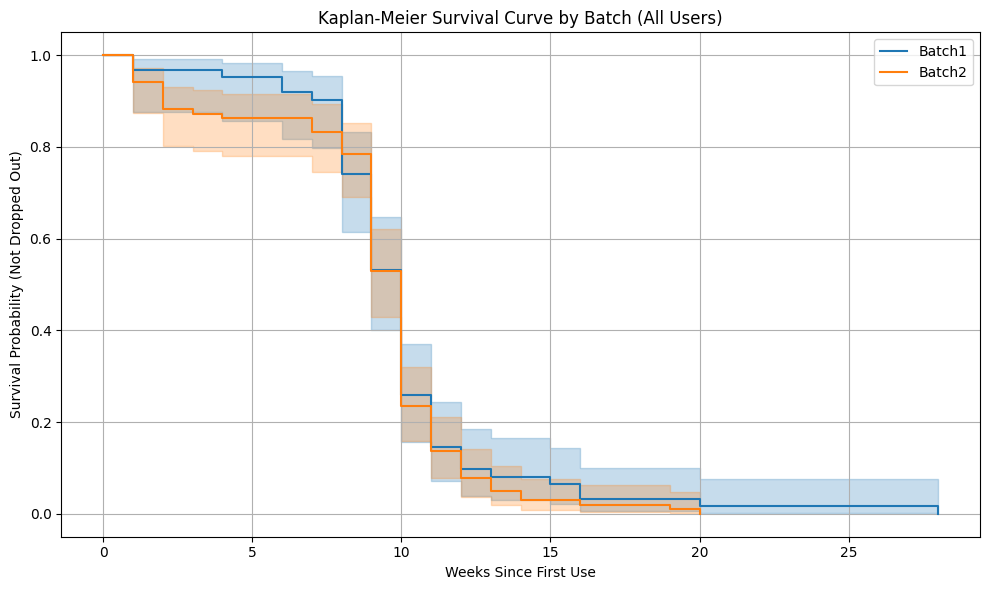

In [44]:
#전체사용자분석

# 🔹 사전 정의
EXPECTED_SAMPLES_PER_WEEK = (7 * 24 * 60) // 5  # 2016
BATCHES = ["Batch1", "Batch2"]
weekly_sample_map_path = Path("./analysis_outputs/weekly_sample_map.pkl")

# 🔹 weekly_sample_map 불러오기
import pickle
with open(weekly_sample_map_path, "rb") as f:
    weekly_sample_map = pickle.load(f)

def prepare_survival_data(weekly_sample_map, user_ids=None):
    durations, events, batches, valid_ids = [], [], [], []

    if user_ids is None:
        user_ids = list(weekly_sample_map.keys())

    for user_id in user_ids:
        week_data = weekly_sample_map.get(user_id, {})
        if not week_data:
            continue

        sorted_weeks = sorted(week_data.items())
        weeks_with_data = [w for w, c in sorted_weeks if c > 0]
        if not weeks_with_data:
            continue

        last_week = max(weeks_with_data)
        all_weeks = {w for w, _ in sorted_weeks}
        after_last = sorted([w for w in all_weeks if w > last_week])

        # 🔹 이탈 판단: 이후 모든 주에 수집률이 0인 경우만 dropout으로 간주
        dropped_out = all(week_data.get(w, 0) == 0 for w in after_last)

        durations.append(last_week + 1)
        events.append(1 if dropped_out else 0)
        valid_ids.append(user_id)
        batches.append(infer_batch(user_id))

    df = pd.DataFrame({
        "user_id": valid_ids,
        "duration": durations,
        "event": events,
        "batch": batches
    })

    print("📊 Survival Data Summary:")
    print(df.groupby('batch')['duration'].describe())
    print("\n📊 Batch별 사용자 수 및 dropout 비율:")
    print(df.groupby('batch')['event'].value_counts(normalize=True).unstack().round(2))
    return df

def infer_batch(user_id):
    num = int(user_id.split("usr")[-1])
    return "Batch1" if num < 660 else "Batch2"
# 🔹 데이터프레임 생성
survival_df = prepare_survival_data(weekly_sample_map)

# 🔹 Kaplan-Meier 시각화
plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

for batch in survival_df["batch"].unique():
    if batch == "Unknown":
        continue
    subset = survival_df[survival_df["batch"] == batch]
    kmf.fit(durations=subset["duration"], event_observed=subset["event"], label=batch)
    kmf.plot_survival_function()

plt.title("Kaplan-Meier Survival Curve by Batch (All Users)")
plt.xlabel("Weeks Since First Use")
plt.ylabel("Survival Probability (Not Dropped Out)")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Dropout users Weekly data submission rate

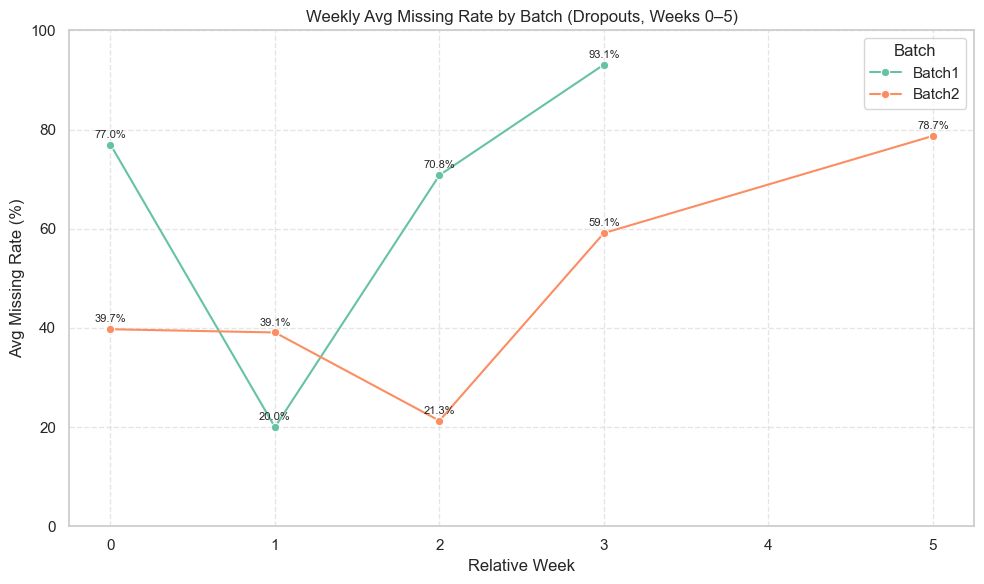

▶ Dropout Users' Weekly Missing Rate Stats (Weeks 0–5):

             count   mean    std    min    25%    50%    75%    max
Week Batch                                                         
0    Batch1    5.0  76.98  23.38  47.57  57.29  84.28  96.18  99.60
     Batch2   17.0  39.74  44.65   0.00   0.35   2.98  92.81  99.75
1    Batch1    2.0  19.99  25.18   2.18  11.09  19.99  28.89  37.80
     Batch2    9.0  39.08  37.40   0.05   1.34  27.88  73.26  93.11
2    Batch1    2.0  70.81  14.98  60.22  65.51  70.81  76.10  81.40
     Batch2    3.0  21.28  17.69   1.64  13.94  26.24  31.10  35.96
3    Batch1    2.0  93.11   9.68  86.26  89.68  93.11  96.53  99.95
     Batch2    1.0  59.13    NaN  59.13  59.13  59.13  59.13  59.13
5    Batch2    1.0  78.72    NaN  78.72  78.72  78.72  78.72  78.72


In [157]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ─── 설정 ───────────────────────────────────────────────────────────────
BASE_PATH = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
SENSOR_FOLDER = "source_12"
SENSOR_FILE = "data_source_12.csv"
EXPECTED_SAMPLES_PER_WEEK = (7 * 24 * 60) // 5  # = 2016
sns.set(style="whitegrid")

batch1_ids = [542, 584, 597, 601, 608, 613, 617, 618, 621, 631, 639, 645]
batch2_ids = [662,663,666,669,682,683,689,701,704,716,723,725,726,727,736,746,756,765,767,769]
dropout_users = [f"cmp1_usr{uid}" for uid in batch1_ids + batch2_ids]

def build_dropout_weekly_records():
    recs = []
    for uid in dropout_users:
        num = int(uid.replace("cmp1_usr",""))
        batch = "Batch1" if num in batch1_ids else "Batch2"
        fp = BASE_PATH/batch/uid/SENSOR_FOLDER/SENSOR_FILE
        if not fp.exists(): continue
        df = pd.read_csv(fp, usecols=["timestamp"])
        df["ts"] = pd.to_datetime(df["timestamp"], errors="coerce")
        df = df.dropna(subset=["ts"]).drop_duplicates(["ts"])
        if df.empty: continue
        start = df["ts"].min()
        df["week"] = ((df["ts"]-start).dt.days//7).astype(int)
        def count_valid(xs):
            xs = xs.sort_values().reset_index(drop=True)
            last, cnt = xs.iloc[0], 1
            for x in xs.iloc[1:]:
                if (x-last).total_seconds()>=300:
                    cnt+=1; last=x
            return cnt
        wc = df.groupby("week")["ts"].apply(count_valid).to_dict()
        for wk,cnt in wc.items():
            recs.append({
                "Batch": batch,
                "Week": wk,
                "MissingRate": (1 - cnt/EXPECTED_SAMPLES_PER_WEEK)*100
            })
    return pd.DataFrame(recs)

# ─── 실행 & 전처리 ─────────────────────────────────────────────────────
df = build_dropout_weekly_records()
df6 = df[df["Week"].between(0,5)].copy()   # Week0~5

# ─── (A) 시각화 ─────────────────────────────────────────────────────────
plt.figure(figsize=(10, 6))
sns.lineplot(data=df6.groupby(["Batch","Week"])["MissingRate"].mean().reset_index(),
             x="Week",y="MissingRate",hue="Batch",marker="o",palette="Set2")
for _, row in df6.groupby(["Batch","Week"])["MissingRate"].mean().reset_index().iterrows():
    plt.text(row["Week"], row["MissingRate"]+1, f"{row['MissingRate']:.1f}%",
             ha="center",va="bottom",fontsize=8)
plt.title("Weekly Avg Missing Rate by Batch (Dropouts, Weeks 0–5)")
plt.xlabel("Relative Week")
plt.ylabel("Avg Missing Rate (%)")
plt.ylim(0,100); plt.xticks(range(0,6))
plt.grid(True,linestyle="--",alpha=0.5); plt.legend(title="Batch")
plt.tight_layout(); plt.show()

# ─── (B) Batch×Week별 기술통계량 출력 ────────────────────────────────────
stats = (
    df6
    .groupby(["Week","Batch"])["MissingRate"]
    .describe(percentiles=[.25,.5,.75])
    .loc[:, ["count","mean","std","min","25%","50%","75%","max"]]
    .round(2)
)
print("▶ Dropout Users' Weekly Missing Rate Stats (Weeks 0–5):\n")
print(stats)

### 회복자 분석

In [57]:
import pandas as pd
from pathlib import Path

# ─── 설정 ───────────────────────────────────────────────────────────────
BASE_PATH = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
SENSOR_FOLDER = "source_12"
SENSOR_FILE = "data_source_12.csv"

# Dropout 사용자 ID 리스트
batch1_ids = [542, 584, 597, 601, 608, 613, 617, 618, 621, 631, 639, 645]
batch2_ids = [662, 663, 666, 669, 682, 683, 689, 701, 704, 716, 723, 725,
              726, 727, 736, 746, 756, 765, 767, 769]
dropout_users = {f"cmp1_usr{uid}" for uid in batch1_ids + batch2_ids}

# Batch 판정
def infer_batch(uid):
    num = int(uid.replace("cmp1_usr", ""))
    return "Batch1" if num < 654 else "Batch2"

# ─── 5분 필터링 포함 주차별 샘플 수 맵 생성 ─────────────────────────────────
def build_weekly_sample_map():
    user_week_map = {}
    for batch in ["Batch1","Batch2"]:
        for uf in (BASE_PATH/batch).glob("cmp1_usr*"):
            uid = uf.name
            path = uf/SENSOR_FOLDER/SENSOR_FILE
            if not path.exists():
                user_week_map[uid] = {}
                continue
            df = pd.read_csv(path, usecols=["timestamp"])
            if df.empty:
                user_week_map[uid] = {}
                continue
            df["ts"] = pd.to_datetime(df["timestamp"], errors="coerce")
            df = df.dropna(subset=["ts"]).drop_duplicates(["ts"])
            if df.empty:
                user_week_map[uid] = {}
                continue
            start = df["ts"].min()
            df["week"] = ((df["ts"]-start).dt.days//7).astype(int)
            def count_valid(xs):
                xs = xs.sort_values().reset_index(drop=True)
                last, cnt = xs.iloc[0], 1
                for x in xs.iloc[1:]:
                    if (x-last).total_seconds() >= 300:
                        cnt += 1
                        last = x
                return cnt
            user_week_map[uid] = df.groupby("week")["ts"].apply(count_valid).to_dict()
    return user_week_map

weekly_map = build_weekly_sample_map()

# ─── 1) Dropout 이후 복귀 탐지 ─────────────────────────────────────────────
rec1 = []
for uid in sorted(dropout_users, key=lambda u: int(u.replace("cmp1_usr",""))):
    weeks = weekly_map.get(uid, {})
    if not weeks:
        drop_w = 0
        recovered = False
    else:
        max_w = max(weeks.keys())
        # 0~max_w 사이에서 첫 0주차
        drop_w = next((w for w in range(max_w+1) if weeks.get(w,0)==0), None)
        # 이후 아무때나 복귀
        recovered = (drop_w is not None) and any(weeks.get(w,0)>0 for w in range(drop_w+1, max_w+1))
    rec1.append({
        "User": uid,
        "Batch": infer_batch(uid),
        "DropoutWeek": drop_w,
        "RecoveredAfterDropout": recovered
    })
df_recover1 = pd.DataFrame(rec1)

# ─── 2) Non-Dropout 중 일시적 0% 후 복귀 탐지 ──────────────────────────────
rec2 = []
for uid, weeks in weekly_map.items():
    if uid in dropout_users:
        continue
    if not weeks:
        zero_w = None
        recovered = False
    else:
        max_w = max(weeks.keys())
        zero_w = None
        recovered = False
        for w in range(max_w+1):
            if weeks.get(w,0)==0:
                # 이후 아무때나 복귀
                if any(weeks.get(x,0)>0 for x in range(w+1, max_w+1)):
                    zero_w = w
                    recovered = True
                    break
    rec2.append({
        "User": uid,
        "Batch": infer_batch(uid),
        "ZeroWeek": zero_w,
        "RecoveredAfterZero": recovered
    })
df_recover2 = pd.DataFrame(rec2)

# ─── 결과 집계 ───────────────────────────────────────────────────────────
# 1) Dropout Users
print("1) Dropout Users Recovery After Dropout:")
print(
    df_recover1
      .groupby("Batch")["RecoveredAfterDropout"]
      .value_counts()
      .unstack(fill_value=0)
, "\n")

# 2) Non-Dropout Users
summary2 = (
    df_recover2
      .groupby("Batch")["RecoveredAfterZero"]
      .value_counts()
      .unstack(fill_value=0)
)

# Batch1, Batch2가 항상 보이도록 재색인
summary2 = summary2.reindex(index=["Batch1","Batch2"], fill_value=0)

print("2) Non-Dropout Users Zero->Recovered:")
print(summary2)
# 필요시 엑셀 저장
# df_recover1.to_excel("recover_after_dropout.xlsx", index=False)
# df_recover2.to_excel("recover_after_zero.xlsx", index=False)

1) Dropout Users Recovery After Dropout:
RecoveredAfterDropout  False  True 
Batch                              
Batch1                    10      2
Batch2                    17      3 

2) Non-Dropout Users Zero->Recovered:
RecoveredAfterZero  False  True 
Batch                           
Batch1                 43     11
Batch2                 76     12


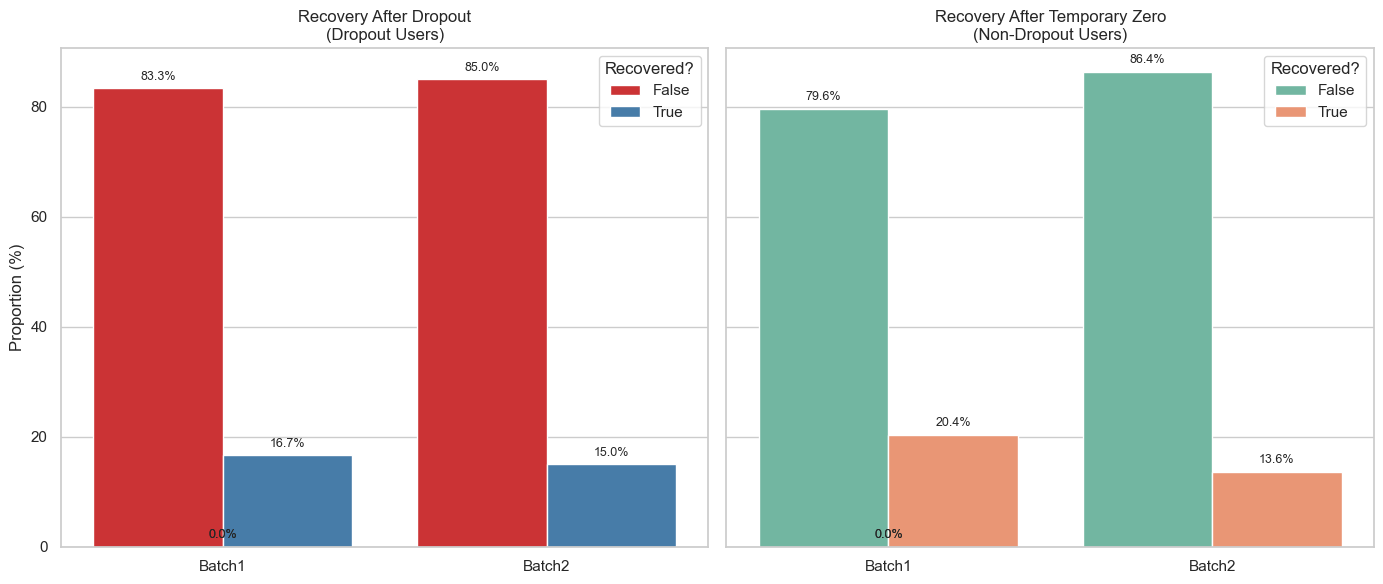

In [58]:
sns.set(style="whitegrid")

# ─── (1) 데이터 준비 ──────────────────────────────────────────────────────
# df_recover1, df_recover2 는 앞에서 만든 DataFrame 이라고 가정합니다.

# 1) Dropout Users Recovery
summary1 = (
    df_recover1
      .groupby(["Batch","RecoveredAfterDropout"])
      .size()
      .reset_index(name="Count")
)
# 배치별 전체 수
summary1["Total"] = summary1.groupby("Batch")["Count"].transform("sum")
# 비율 계산
summary1["Pct"] = summary1["Count"] / summary1["Total"] * 100

# 2) Non-Dropout Temporary Zero-Recovery
summary2 = (
    df_recover2
      .groupby(["Batch","RecoveredAfterZero"])
      .size()
      .reset_index(name="Count")
)
summary2["Total"] = summary2.groupby("Batch")["Count"].transform("sum")
summary2["Pct"] = summary2["Count"] / summary2["Total"] * 100

# ─── (2) 시각화 ───────────────────────────────────────────────────────────

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

# 1) Dropout Users
sns.barplot(
    data=summary1,
    x="Batch", y="Pct", hue="RecoveredAfterDropout",
    palette="Set1", ax=axes[0]
)
axes[0].set_title("Recovery After Dropout\n(Dropout Users)")
axes[0].set_ylabel("Proportion (%)")
axes[0].set_xlabel("")
for p in axes[0].patches:
    h = p.get_height()
    axes[0].text(
        p.get_x()+p.get_width()/2, h+1,
        f"{h:.1f}%", ha="center", va="bottom", fontsize=9
    )

# 2) Non-Dropout Users
sns.barplot(
    data=summary2,
    x="Batch", y="Pct", hue="RecoveredAfterZero",
    palette="Set2", ax=axes[1]
)
axes[1].set_title("Recovery After Temporary Zero\n(Non-Dropout Users)")
axes[1].set_ylabel("")
axes[1].set_xlabel("")
for p in axes[1].patches:
    h = p.get_height()
    axes[1].text(
        p.get_x()+p.get_width()/2, h+1,
        f"{h:.1f}%", ha="center", va="bottom", fontsize=9
    )

# 범례 제목 조정
axes[0].legend(title="Recovered?")
axes[1].legend(title="Recovered?")

plt.tight_layout()
plt.show()

### Avg. Data Submission Rate

    Batch  TotalUsers  NumAbove  PctAbove (%)
0  Batch1          66        49     74.242424
1  Batch2         108        77     71.296296


/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/922766837.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


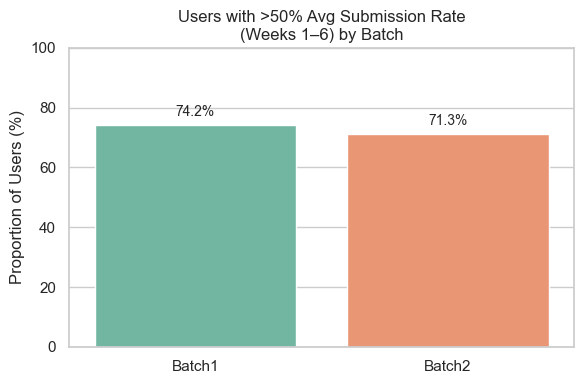

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ─── 설정 ────────────────────────────────────────────────────────────────
xlsx = Path("analysis_outputs/weekly_sensor_collection_rate_percent.xlsx")

# Dropout 리스트 (필터링은 여기선 불필요—전체 유저 대상으로)
#drop1 = [542,584,597,601,608,613,617,618,621,631,639,645]
#drop2 = [662,663,666,669,682,683,689,701,704,716,723,725,726,727,736,746,756,765,767,769]
drop1 = []
drop2 = []
dropout = {f"cmp1_usr{u}" for u in drop1+drop2}

# ─── 1) 엑셀 읽기 ─────────────────────────────────────────────────────────
df = pd.read_excel(xlsx, index_col=0)

# ─── 2) 주차 컬럼(숫자)만 골라 정수형으로 변환 ───────────────────────────────
week_cols = sorted(int(c) for c in df.columns if str(c).isdigit())

# ─── 3) 0~6주차만 선택해서 평균 제출률 계산 ────────────────────────────────
selected_weeks = [w for w in week_cols if w <= 5]
df["AvgRate_0_6"] = df[selected_weeks].mean(axis=1)

# ─── 4) Batch 컬럼 추가 ──────────────────────────────────────────────────
def infer_batch(uid):
    n = int(uid.replace("cmp1_usr",""))
    return "Batch1" if n < 654 else "Batch2"

df["Batch"] = df.index.to_series().apply(infer_batch)

# ─── 5) 50% 초과 유저 플래그 ──────────────────────────────────────────────
cutoff = 50.0
df["Above50_0_6"] = df["AvgRate_0_6"] > cutoff

# ─── 6) 배치별 통계 집계 ─────────────────────────────────────────────────
summary = (
    df
      .groupby("Batch")["Above50_0_6"]
      .agg(TotalUsers="count", NumAbove="sum")
      .reset_index()
)
summary["PctAbove (%)"] = summary["NumAbove"] / summary["TotalUsers"] * 100

print(summary)

# ─── 7) 시각화 ───────────────────────────────────────────────────────────
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))

# 비율 막대그래프
ax = sns.barplot(
    data=summary,
    x="Batch", y="PctAbove (%)",
    palette=["#66C2A5", "#FC8D62"]
)

# 각 막대 위에 실제 퍼센트 표시
for i, row in summary.iterrows():
    ax.text(
        i, row["PctAbove (%)"] + 2,
        f"{row['PctAbove (%)']:.1f}%",
        ha="center", va="bottom", fontsize=10
    )

plt.ylim(0, 100)
plt.title("Users with >50% Avg Submission Rate\n(Weeks 1–6) by Batch")
plt.ylabel("Proportion of Users (%)")
plt.xlabel("")
plt.tight_layout()
plt.show()

▶ 마지막 제출 주차까지 평균 제출률이 30% 초과인 사용자 비율 (배치별):
 Batch  TotalUsers  NumAbove  PctAbove (%)
Batch1          66        47          71.2
Batch2         108        86          79.6


/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/1743461091.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


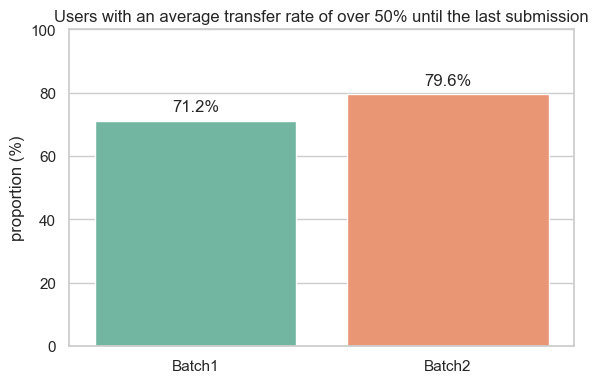

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

# 1) 엑셀 불러오기
xlsx = Path("analysis_outputs/weekly_sensor_collection_rate_percent.xlsx")
df = pd.read_excel(xlsx, index_col=0)

# 2) 컬럼명을 정수형 주차로 변환
#    예: 컬럼이 모두 '0','1',… 형태라면 int로 바꿔줍니다.
df.columns = [int(c) for c in df.columns if str(c).isdigit()]
week_cols = sorted(df.columns)

# 3) 마지막 데이터 수집 주차까지 평균 제출률 계산 함수
def avg_until_last_positive(row):
    # 제출률 > 0인 주차 찾기
    positive_weeks = [w for w in week_cols if row[w] > 0]
    if not positive_weeks:
        return 0.0
    last = max(positive_weeks)
    # 0주차부터 last주차까지 컬럼 리스트
    cols = list(range(0, last + 1))
    return row[cols].mean()

df["AvgRate_UntilLast"] = df.apply(avg_until_last_positive, axis=1)

# 4) Batch 정보 추가
def infer_batch(uid):
    n = int(uid.replace("cmp1_usr", ""))
    return "Batch1" if n < 654 else "Batch2"

df["Batch"] = df.index.to_series().apply(infer_batch)

# 5) 컷오프 플래그 설정 (예: 30%)
cutoff = 50.0
df["Above30"] = df["AvgRate_UntilLast"] > cutoff

# 6) 배치별 집계
summary = (
    df
      .groupby("Batch")["Above30"]
      .agg(TotalUsers="count", NumAbove="sum")
      .reset_index()
)
summary["PctAbove (%)"] = (summary["NumAbove"] / summary["TotalUsers"] * 100).round(1)

print("▶ 마지막 제출 주차까지 평균 제출률이 30% 초과인 사용자 비율 (배치별):")
print(summary.to_string(index=False))

# 7) 시각화
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
ax = sns.barplot(
    data=summary,
    x="Batch", y="PctAbove (%)",
    palette=["#66C2A5", "#FC8D62"]
)
for i, row in summary.iterrows():
    ax.text(i, row["PctAbove (%)"] + 2,
            f"{row['PctAbove (%)']:.1f}%",
            ha="center", va="bottom")
plt.ylim(0,100)
plt.title("Users with an average transfer rate of over 50% until the last submission")
plt.ylabel("proportion (%)")
plt.xlabel("")
plt.tight_layout()
plt.show()

▶ Dropout 제외 후, 마지막 제출 주차까지 평균 제출률이 30% 초과인 사용자 비율 (배치별):
 Batch  TotalUsers  NumAbove  PctAbove (%)
Batch1          54        15          27.8
Batch2          88        34          38.6


/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/3680251306.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


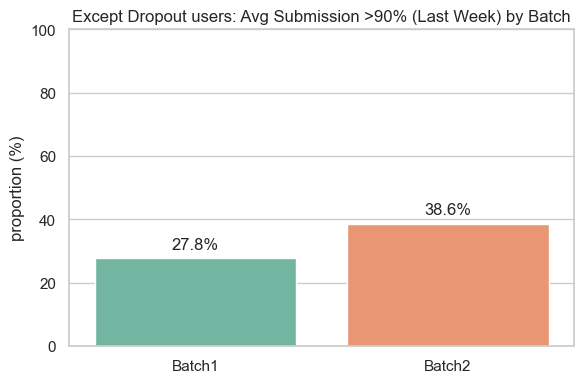

In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 1) 설정
xlsx = Path("analysis_outputs/weekly_sensor_collection_rate_percent.xlsx")

# 2) 드롭아웃 사용자 ID 리스트
drop1 = [542,584,597,601,608,613,617,618,621,631,639,645]
drop2 = [662,663,666,669,682,683,689,701,704,716,723,725,726,727,736,746,756,765,767,769]
dropout = {f"cmp1_usr{u}" for u in drop1 + drop2}

# 3) 엑셀 불러오기 & 주차 컬럼 추출
df = pd.read_excel(xlsx, index_col=0)
week_cols = sorted(int(c) for c in df.columns if str(c).isdigit())
# 컬럼명을 정수로 바꿔두면 접근이 편합니다
df.columns = week_cols

# 4) Dropout 사용자 제외
df = df.loc[~df.index.isin(dropout)]

# 5) 마지막 제출 주차까지 평균 제출률 계산
def avg_until_last_positive(row):
    positive_weeks = [w for w in week_cols if row[w] > 0]
    if not positive_weeks:
        return 0.0
    last = max(positive_weeks)
    return row[list(range(0, last+1))].mean()

df["AvgRate_UntilLast"] = df.apply(avg_until_last_positive, axis=1)

# 6) Batch 정보 추가
def infer_batch(uid):
    n = int(uid.replace("cmp1_usr",""))
    return "Batch1" if n < 654 else "Batch2"
df["Batch"] = df.index.to_series().apply(infer_batch)

# 7) 컷오프 플래그 (예: 30%)
cutoff = 90.0
df["Above30"] = df["AvgRate_UntilLast"] > cutoff

# 8) 배치별 집계
summary = (
    df
      .groupby("Batch")["Above30"]
      .agg(TotalUsers="count", NumAbove="sum")
      .reset_index()
)
summary["PctAbove (%)"] = (summary["NumAbove"] / summary["TotalUsers"] * 100).round(1)

print("▶ Dropout 제외 후, 마지막 제출 주차까지 평균 제출률이 30% 초과인 사용자 비율 (배치별):")
print(summary.to_string(index=False))

# 9) 시각화
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
ax = sns.barplot(
    data=summary,
    x="Batch", y="PctAbove (%)",
    palette=["#66C2A5", "#FC8D62"]
)
for i, row in summary.iterrows():
    ax.text(i, row["PctAbove (%)"] + 2,
            f"{row['PctAbove (%)']:.1f}%",
            ha="center", va="bottom")
plt.ylim(0,100)
plt.title("Except Dropout users: Avg Submission >90% (Last Week) by Batch")
plt.ylabel("proportion (%)")
plt.xlabel("")
plt.tight_layout()
plt.show()

### 전체 사용기간 for Non-Dropout Users

▶ Sample of result:
          User   Batch  LastWeek  WeeksWithData
0  cmp1_usr541  Batch1         9             10
1  cmp1_usr545  Batch1         5              6
2  cmp1_usr546  Batch1        15             16
3  cmp1_usr547  Batch1        11             12
4  cmp1_usr559  Batch1         6              7 

▶ Descriptive statistics by Batch:
Batch                   Batch1     Batch2
LastWeek      count  57.000000  85.000000
              mean    9.228070   9.258824
              std     3.354195   2.110929
              min     5.000000   6.000000
              25%     8.000000   8.000000
              50%     9.000000   9.000000
              75%     9.000000  10.000000
              max    27.000000  19.000000
WeeksWithData count  57.000000  85.000000
              mean    9.894737  10.070588
              std     2.643619   1.956602
              min     6.000000   6.000000
              25%     8.000000   9.000000
              50%     9.000000  10.000000
              75%    10.0

/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/569969948.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=result, x="Batch", y="LastWeek", ax=axes[0], palette="Set2")
/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/569969948.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=result, x="Batch", y="WeeksWithData", ax=axes[1], palette="Set2")


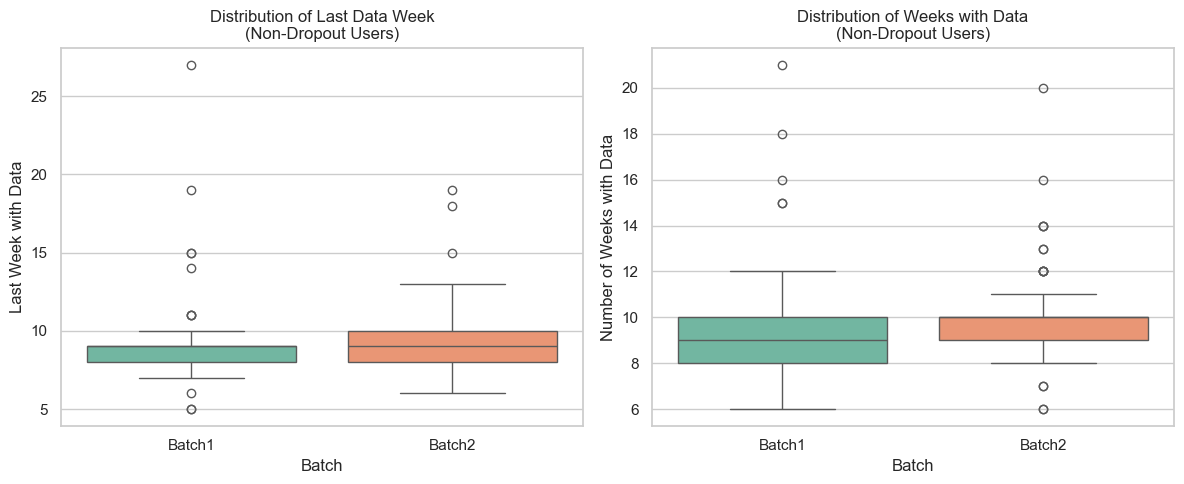

/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/569969948.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=result, x="Batch", y="LastWeek", ax=axes[0], palette="Set2")
/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/569969948.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=result, x="Batch", y="WeeksWithData", ax=axes[1], palette="Set2")


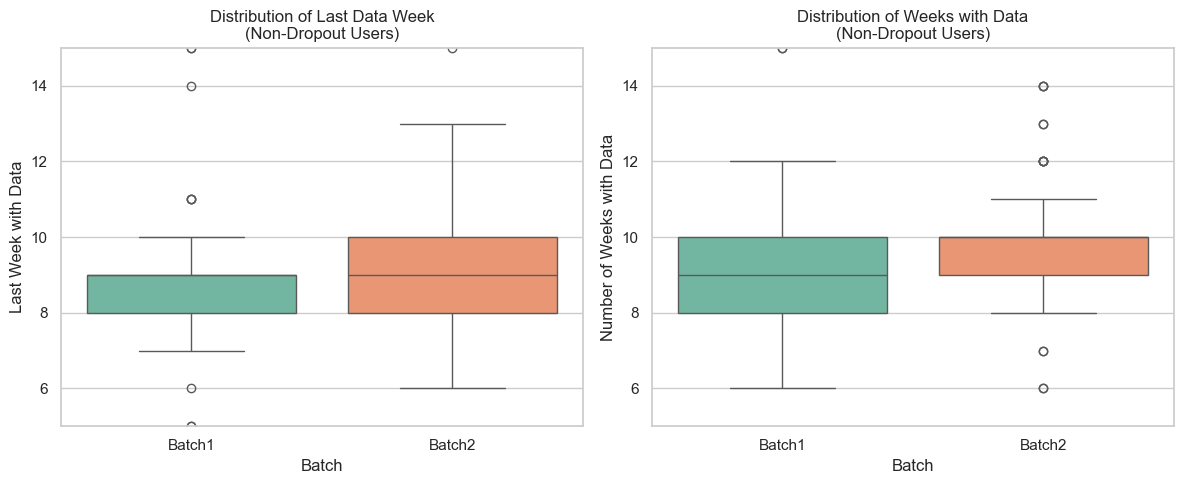

📊 Descriptive Statistics by Batch:
       LastWeek                                        WeeksWithData         \
          count  mean   std  min  25%  50%   75%   max         count   mean   
Batch                                                                         
Batch1     57.0  9.23  3.35  5.0  8.0  9.0   9.0  27.0          57.0   9.89   
Batch2     85.0  9.26  2.11  6.0  8.0  9.0  10.0  19.0          85.0  10.07   

                                          
         std  min  25%   50%   75%   max  
Batch                                     
Batch1  2.64  6.0  8.0   9.0  10.0  21.0  
Batch2  1.96  6.0  9.0  10.0  10.0  20.0  


In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ─── 설정 ────────────────────────────────────────────────────────────────
xlsx_path = Path("analysis_outputs/weekly_sensor_collection_rate_percent.xlsx")

# Dropout 사용자 ID 리스트
batch1_ids = [542,584,597,601,608,613,617,618,621,631,639,645]
batch2_ids = [662,663,666,669,682,683,689,701,704,716,723,725,726,727,736,746,756,765,767,769]
dropout = {f"cmp1_usr{u}" for u in batch1_ids + batch2_ids}

# ─── 1) 엑셀 불러오기 & 주차 컬럼 식별 ────────────────────────────────────
df = pd.read_excel(xlsx_path, index_col=0)
week_cols = sorted(int(c) for c in df.columns if str(c).isdigit())
df.columns = week_cols

# ─── 2) Non-Dropout Users 필터링 ────────────────────────────────────────
non_do = [uid for uid in df.index if uid not in dropout]
nd_df = df.loc[non_do].copy()

# ─── 3) Batch 컬럼 추가 ──────────────────────────────────────────────────
def infer_batch(uid):
    n = int(uid.replace("cmp1_usr",""))
    return "Batch1" if n < 660 else "Batch2"

nd_df["Batch"] = nd_df.index.to_series().apply(infer_batch)

# ─── 4) 전체 사용 기간: 마지막 데이터 수집 주차 ──────────────────────────
def calc_last_week(row):
    weeks_with_data = [w for w, val in zip(week_cols, row[week_cols]) if val > 0]
    return max(weeks_with_data) if weeks_with_data else np.nan

nd_df["LastWeek"] = nd_df.apply(calc_last_week, axis=1)

# ─── 5) 데이터 수집이 있는 주차만 사용: 주차 수 계산 ───────────────────────
nd_df["WeeksWithData"] = (nd_df[week_cols] > 0).sum(axis=1)

# ─── 6) 결과 확인 ─────────────────────────────────────────────────────────
result = nd_df[["Batch", "LastWeek", "WeeksWithData"]].reset_index().rename(columns={"index":"User"})
print("▶ Sample of result:")
print(result.head(), "\n")

# ─── 7) 배치별 기술 통계 ───────────────────────────────────────────────────
stats = result.groupby("Batch")[["LastWeek","WeeksWithData"]].describe().T
print("▶ Descriptive statistics by Batch:")
print(stats)

# ─── 8) 시각화 ───────────────────────────────────────────────────────────
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=False)

# (1) LastWeek 분포
sns.boxplot(data=result, x="Batch", y="LastWeek", ax=axes[0], palette="Set2")
axes[0].set_title("Distribution of Last Data Week\n(Non-Dropout Users)")
axes[0].set_ylabel("Last Week with Data")

# (2) WeeksWithData 분포
sns.boxplot(data=result, x="Batch", y="WeeksWithData", ax=axes[1], palette="Set2")
axes[1].set_title("Distribution of Weeks with Data\n(Non-Dropout Users)")
axes[1].set_ylabel("Number of Weeks with Data")

plt.tight_layout()
plt.show()

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# (1) LastWeek 분포
sns.boxplot(data=result, x="Batch", y="LastWeek", ax=axes[0], palette="Set2")
axes[0].set_title("Distribution of Last Data Week\n(Non-Dropout Users)")
axes[0].set_ylabel("Last Week with Data")
axes[0].set_ylim(5, 15)  # 필요시 적절히 조정

# (2) WeeksWithData 분포
sns.boxplot(data=result, x="Batch", y="WeeksWithData", ax=axes[1], palette="Set2")
axes[1].set_title("Distribution of Weeks with Data\n(Non-Dropout Users)")
axes[1].set_ylabel("Number of Weeks with Data")
axes[1].set_ylim(5, 15)  # 필요시 적절히 조정

plt.tight_layout()
plt.show()

# 🔹 Batch별 기초 통계량 계산
summary_stats = (
    result
    .groupby("Batch")[["LastWeek", "WeeksWithData"]]
    .describe()
    .round(2)
)

# 🔹 보기 쉽게 포맷팅
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    print("📊 Descriptive Statistics by Batch:")
    print(summary_stats)

Batch1: 66it [00:03, 17.88it/s]
Batch2: 108it [00:05, 19.90it/s]
/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/12631753.py:77: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


▶ Weekly Missing Rate Stats (Dropouts Excluded)

       count          mean           std       
Batch Batch1 Batch2 Batch1 Batch2 Batch1 Batch2
Week                                           
0       54.0   88.0  13.85  16.64  24.48  23.78
1       54.0   88.0  15.97  18.15  25.58  24.64
2       54.0   88.0  15.62  16.22  24.69  23.87
3       54.0   88.0  16.43  18.19  26.70  26.49
4       54.0   88.0  16.04  20.41  27.24  27.49
5       54.0   88.0  22.42  19.10  30.57  28.09


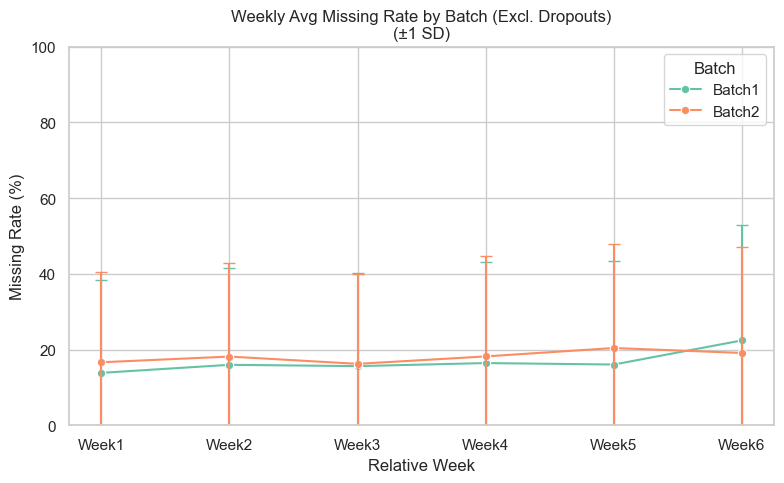

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm

# ─── 설정 ───────────────────────────────────────────────────────────────
BASE_PATH = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
BATCHES = ["Batch1","Batch2"]
SENSOR_FOLDER = "source_12"
SENSOR_FILE = "data_source_12.csv"
EXPECTED_PER_WEEK = (7*24*60)//5  # =2016
MAX_REL_WEEK = 6  # 0~5
sns.set(style="whitegrid")

# 드롭아웃 사용자 집합
batch1 = [542,584,597,601,608,613,617,618,621,631,639,645]
batch2 = [662,663,666,669,682,683,689,701,704,716,723,725,726,727,736,746,756,765,767,769]
dropouts = {f"cmp1_usr{u}" for u in batch1+batch2}

# ─── 1) 데이터 수집 및 재베이스 ─────────────────────────────────────────
records = []
for batch in BATCHES:
    for usr_dir in tqdm((BASE_PATH/batch).glob("cmp1_usr*"), desc=batch):
        uid = usr_dir.name
        if uid in dropouts:  # 드롭아웃 제외
            continue
        fp = usr_dir/SENSOR_FOLDER/SENSOR_FILE
        if not fp.exists():
            continue

        df = pd.read_csv(fp, usecols=["timestamp"])
        df["ts"] = pd.to_datetime(df["timestamp"], errors="coerce")
        df = df.dropna(subset=["ts"]).drop_duplicates(["ts"])
        if df.empty:
            continue

        first_ts = df["ts"].min()
        df["week_offset"] = ((df["ts"] - first_ts).dt.days // 7).astype(int)

        def count_valid(series):
            s = series.sort_values().reset_index(drop=True)
            last, cnt = s.iloc[0], 1
            for t in s.iloc[1:]:
                if (t - last).total_seconds() >= 300:
                    cnt += 1
                    last = t
            return cnt

        wk_counts = df.groupby("week_offset")["ts"].apply(count_valid).to_dict()

        for w in range(MAX_REL_WEEK):
            cnt = wk_counts.get(w, 0)
            missing = 1 - cnt/EXPECTED_PER_WEEK
            records.append({
                "Batch": batch,
                "Week": w,  # 숫자 0~5
                "MissingRate": missing*100
            })

df_box = pd.DataFrame(records)

# ─── 2) 통계 테이블 출력 ─────────────────────────────────────────────────
stats = (
    df_box
    .groupby(["Week","Batch"])["MissingRate"]
    .agg(count="count", mean="mean", std="std")
    .round(2)
    .reset_index()
)
print("▶ Weekly Missing Rate Stats (Dropouts Excluded)\n")
print(stats.pivot(index="Week", columns="Batch", values=["count","mean","std"]))

# ─── 3) 꺾은선 그래프 (mean ± std) ───────────────────────────────────────
plt.figure(figsize=(8,5))
sns.lineplot(
    data=df_box,
    x="Week", y="MissingRate", hue="Batch",
    ci=None, estimator=np.mean, marker="o", palette="Set2"
)

# 에러바 직접 추가
for batch in BATCHES:
    df_b = stats[stats["Batch"]==batch]
    plt.errorbar(
        df_b["Week"], df_b["mean"],
        yerr=df_b["std"],
        fmt="none",
        capsize=4,
        color=sns.color_palette("Set2")[BATCHES.index(batch)]
    )

plt.xticks(range(MAX_REL_WEEK), [f"Week{w}" for w in range(1,MAX_REL_WEEK+1)])
plt.ylim(0, 100)
plt.title("Weekly Avg Missing Rate by Batch (Excl. Dropouts)\n(±1 SD)")
plt.xlabel("Relative Week")
plt.ylabel("Missing Rate (%)")
plt.legend(title="Batch")
plt.tight_layout()
plt.show()

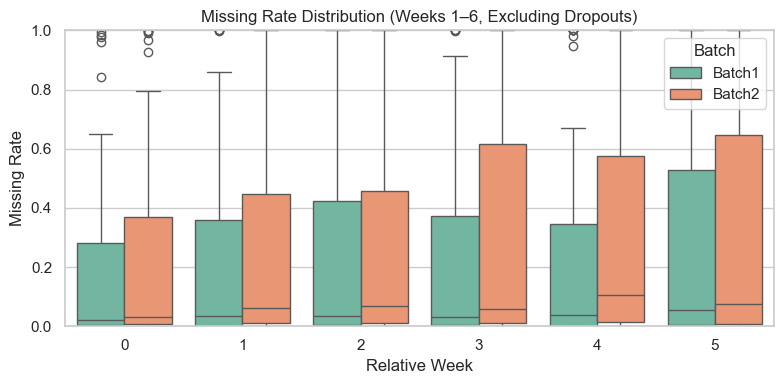

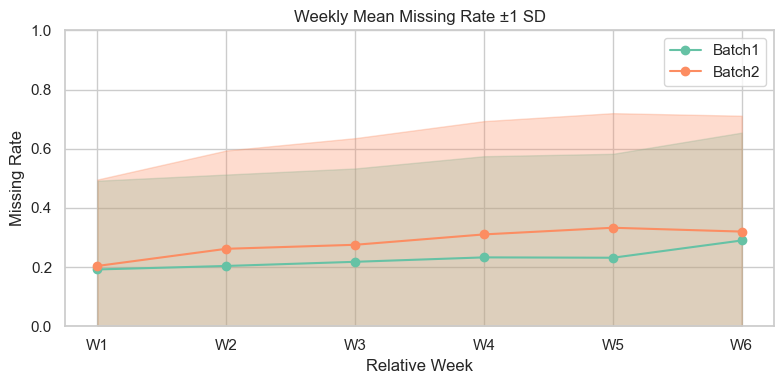

Shapiro Batch1: ShapiroResult(statistic=np.float64(0.7651732323265974), pvalue=np.float64(2.4492029688824174e-08))
Shapiro Batch2: ShapiroResult(statistic=np.float64(0.818856698564907), pvalue=np.float64(5.054442294860187e-10))
Levene test: LeveneResult(statistic=np.float64(1.7193473955276488), pvalue=np.float64(0.19163256132316797))
Welch’s t-test: t=-1.17, p=0.244
Mann-Whitney U: U=2839.0, p=0.377


In [173]:

# 0) Non-dropout 필터링
dropouts = set(dropout_user_ids_batch1 + dropout_user_ids_batch2)
df_non = df_box[~df_box["User"].isin(dropouts)].copy()

# 1) 전체 분포 시각화 (Boxplot of MissingRate)
plt.figure(figsize=(8,4))
sns.boxplot(
    data=df_non[df_non["Week"].between(0,5)],
    x="Week", y="MissingRate", hue="Batch", palette="Set2"
)
plt.ylim(0,1)
plt.title("Missing Rate Distribution (Weeks 1–6, Excluding Dropouts)")
plt.ylabel("Missing Rate")
plt.xlabel("Relative Week")
plt.legend(title="Batch")
plt.tight_layout()
plt.show()

# 2) 주차별 평균 ± SD 꺾은선 (MissingRate)
stats_weekly = (
    df_non[df_non["Week"].between(0,5)]
    .groupby(["Week","Batch"])["MissingRate"]
    .agg(mean="mean", std="std")
    .reset_index()
)

plt.figure(figsize=(8,4))
for batch, color in zip(["Batch1","Batch2"], sns.color_palette("Set2",2)):
    sub = stats_weekly[stats_weekly["Batch"]==batch]
    plt.plot(sub["Week"], sub["mean"], marker="o", color=color, label=batch)
    plt.fill_between(
        sub["Week"],
        sub["mean"]-sub["std"],
        sub["mean"]+sub["std"],
        alpha=0.3, color=color
    )
plt.ylim(0,1)
plt.title("Weekly Mean Missing Rate ±1 SD")
plt.xlabel("Relative Week")
plt.ylabel("Missing Rate")
plt.xticks(range(0,6), [f"W{k+1}" for k in range(6)])
plt.legend()
plt.tight_layout()
plt.show()

# 3) 통계 검정: 사용자별 전체(Week1–6) 평균 MissingRate 비교
user_avg = (
    df_non[df_non["Week"].between(0,5)]
    .groupby(["User","Batch"])["MissingRate"]
    .mean()
    .reset_index()
)

b1 = user_avg[user_avg["Batch"]=="Batch1"]["MissingRate"]
b2 = user_avg[user_avg["Batch"]=="Batch2"]["MissingRate"]

# 정규성 검사
print("Shapiro Batch1:", stats.shapiro(b1))
print("Shapiro Batch2:", stats.shapiro(b2))
# 등분산성 검사
print("Levene test:", stats.levene(b1, b2))
# Welch’s t‐test
t_res = stats.ttest_ind(b1, b2, equal_var=False)
print(f"Welch’s t-test: t={t_res.statistic:.2f}, p={t_res.pvalue:.3f}")
# Mann–Whitney U
mw = stats.mannwhitneyu(b1, b2, alternative="two-sided")
print(f"Mann-Whitney U: U={mw.statistic}, p={mw.pvalue:.3f}")

In [174]:
import pandas as pd

# stats_weekly: 이미 compute_weekly_missing_map() → df_box → df_non 까지 수행 후
# df_non 에서 주차별 그룹 통계(평균·표준편차)만 계산해둔 상태라고 가정

# 1) 주차별•배치별 Descriptive Statistics 계산
desc = (
    df_non[df_non["Week"].between(0,5)]
    .groupby(["Week","Batch"])["MissingRate"]
    .describe()  # count, mean, std, min, 25%, 50%, 75%, max
    .round(3)
)

# 2) 노션 표 복붙용 포맷팅 출력
print("Week | Batch | count | mean | std | min | 25% | 50% | 75% | max")
for (week, batch), row in desc.iterrows():
    print(f"W{week+1} | {batch} | {row['count']} | {row['mean']} | {row['std']} | "
          f"{row['min']} | {row['25%']} | {row['50%']} | {row['75%']} | {row['max']}")

Week | Batch | count | mean | std | min | 25% | 50% | 75% | max
W1 | Batch1 | 59.0 | 0.192 | 0.3 | 0.0 | 0.005 | 0.021 | 0.281 | 0.996
W1 | Batch2 | 105.0 | 0.204 | 0.292 | 0.0 | 0.006 | 0.03 | 0.368 | 0.998
W2 | Batch1 | 59.0 | 0.204 | 0.309 | 0.0 | 0.002 | 0.035 | 0.36 | 1.0
W2 | Batch2 | 105.0 | 0.262 | 0.332 | 0.0 | 0.01 | 0.062 | 0.446 | 1.0
W3 | Batch1 | 59.0 | 0.218 | 0.316 | 0.0 | 0.005 | 0.034 | 0.422 | 1.0
W3 | Batch2 | 105.0 | 0.275 | 0.36 | 0.0 | 0.01 | 0.068 | 0.456 | 1.0
W4 | Batch1 | 59.0 | 0.233 | 0.342 | 0.0 | 0.004 | 0.03 | 0.374 | 1.0
W4 | Batch2 | 105.0 | 0.31 | 0.383 | 0.0 | 0.012 | 0.059 | 0.617 | 1.0
W5 | Batch1 | 59.0 | 0.232 | 0.351 | 0.0 | 0.002 | 0.039 | 0.344 | 1.0
W5 | Batch2 | 105.0 | 0.333 | 0.387 | 0.0 | 0.015 | 0.106 | 0.574 | 1.0
W6 | Batch1 | 59.0 | 0.29 | 0.365 | 0.0 | 0.004 | 0.055 | 0.529 | 1.0
W6 | Batch2 | 105.0 | 0.32 | 0.392 | 0.0 | 0.009 | 0.077 | 0.645 | 1.0


In [177]:
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 2.6 MB/s eta 0:00:0000:0100:01


In [178]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# ─── 0) 설정 ────────────────────────────────────────────────────────────
# 누락률 엑셀 파일 경로 (index_col=0 -> 첫 열이 user_id)
xlsx_path = Path("analysis_outputs/weekly_sensor_collection_rate_percent.xlsx")

# dropout user ID 리스트 (prefix 포함)
batch1_nums = [542,584,597,601,608,613,617,618,621,631,639,645]
batch2_nums = [662,663,666,669,682,683,689,701,704,716,723,725,726,727,736,746,756,765,767,769]
dropout_ids = {f"cmp1_usr{uid}" for uid in batch1_nums + batch2_nums}

# ─── 1) 엑셀 로드 ─────────────────────────────────────────────────────────
# 인덱스: cmp1_usrNNN, 컬럼: 0,1,2,... 주차, 값: MissingRate(%)
df = pd.read_excel(xlsx_path, index_col=0)

# ─── 2) Week0–2 누락률 피처 추출 ────────────────────────────────────────
# 컬럼명이 정수형이라면 바로 슬라이싱
feat = df[[0,1,2]].copy()
feat.columns = ['miss_w0','miss_w1','miss_w2']

# ─── 3) 레이블 생성 ─────────────────────────────────────────────────────
feat['user_id'] = feat.index
feat['is_dropout'] = feat['user_id'].isin(dropout_ids).astype(int)

# ─── 4) 모델 학습을 위한 X, y 준비 ─────────────────────────────────────
X = feat[['miss_w0','miss_w1','miss_w2']]
y = feat['is_dropout']

# 간단히 batch 정보도 붙일 수 있음
feat['batch'] = feat['user_id'].apply(lambda u: 'Batch1' if int(u.replace('cmp1_usr',''))<660 else 'Batch2')

# ─── 5) 학습/테스트 분리 & 스케일링 ────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
scaler = StandardScaler().fit(X_train)
X_tr, X_te = scaler.transform(X_train), scaler.transform(X_test)

# ─── 6) 로지스틱 회귀 학습 ─────────────────────────────────────────────
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_tr, y_train)

# ─── 7) 성능 평가 ─────────────────────────────────────────────────────
y_pred  = model.predict(X_te)
y_proba = model.predict_proba(X_te)[:,1]

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test ROC AUC : ", roc_auc_score(y_test, y_proba))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ─── 8) 5-fold 교차검증 ────────────────────────────────────────────────
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cvres = cross_validate(
    model, scaler.transform(X), y, cv=cv,
    scoring=['accuracy','roc_auc'], return_train_score=False
)
print("5-fold CV Accuracy: %.3f±%.3f" % (
    cvres['test_accuracy'].mean(), cvres['test_accuracy'].std()))
print("5-fold CV ROC AUC : %.3f±%.3f" % (
    cvres['test_roc_auc'].mean(), cvres['test_roc_auc'].std()))

# ─── 9) 회귀계수 & 중요도 ─────────────────────────────────────────────
coefs = pd.Series(model.coef_[0], index=X.columns).sort_values(key=abs, ascending=False)
print("\nFeature coefficients:\n", coefs)

Test Accuracy: 0.8679245283018868
Test ROC AUC :  0.9046511627906978

Confusion Matrix:
 [[37  6]
 [ 1  9]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.86      0.91        43
           1       0.60      0.90      0.72        10

    accuracy                           0.87        53
   macro avg       0.79      0.88      0.82        53
weighted avg       0.90      0.87      0.88        53

5-fold CV Accuracy: 0.908±0.049
5-fold CV ROC AUC : 0.959±0.036

Feature coefficients:
 miss_w2   -2.807963
miss_w1    0.510891
miss_w0    0.067976
dtype: float64


In [179]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# ─── 설정 ───────────────────────────────────────────────────────────────
BASE = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
BATCHES = ["Batch1","Batch2"]
S3 = "source_3/data_source_3.csv"      # Unlock 이벤트
S5 = "source_5/data_source_5.csv"      # AppResume 이벤트
S18= "source_18/data_source_18.csv"    # 제스처·클릭 이벤트
DROP1 = [542,584,597,601,608,613,617,618,621,631,639,645]
DROP2 = [662,663,666,669,682,683,689,701,704,716,723,725,726,727,736,746,756,765,767,769]
dropout_ids = {f"cmp1_usr{u}" for u in DROP1+DROP2}

# helper
def parse_value(val):
    try: return __import__('json').loads(val.replace("'", '"'))
    except: return {}

# 주당 기대 샘플 수 (unlock count 아님, 그냥 레퍼런스)
EXP_PER_WEEK = (7*24*60)//5

# ─── 1) 주차별 Screen Unlock 횟수 수집 (source3) ──────────────────────
unlock = {}
for batch in BATCHES:
    for u in (BASE/batch).glob("cmp1_usr*"):
        uid = u.name
        path = u/S3
        if not path.exists(): continue
        df = pd.read_csv(path)
        df['parsed'] = df['value'].map(parse_value)
        df['ts'] = pd.to_datetime(df['parsed'].map(lambda x: x.get('timestamp')), errors='coerce')
        df = df.dropna(subset=['ts'])
        df['week'] = ((df['ts'] - df['ts'].min()).dt.days//7).astype(int)
        unlock[uid] = df.groupby('week').size().to_dict()

# ─── 2) 주차별 EVApp 재개 비율 (source5) ─────────────────────────────
resume = {}
for batch in BATCHES:
    for u in (BASE/batch).glob("cmp1_usr*"):
        uid = u.name
        path = u/S5
        if not path.exists(): continue
        df = pd.read_csv(path)
        df['parsed'] = df['value'].map(parse_value)
        df['state']  = df['parsed'].map(lambda x: x.get('state'))
        df = df[df['state']=="AppLifecycleState.resumed"]
        df['ts'] = pd.to_datetime(df['parsed'].map(lambda x: x.get('timestamp')), errors='coerce')
        df = df.dropna(subset=['ts'])
        df['week'] = ((df['ts'] - df['ts'].min()).dt.days//7).astype(int)
        # resumed count per week
        res_cnt = df.groupby('week').size()
        # unlock count per week
        un_cnt = unlock.get(uid, {})
        # ratio = resumed / unlock
        resume[uid] = {w: res_cnt.get(w,0)/(un_cnt.get(w,0)+1e-6) for w in range(3)}

# ─── 3) 주차별 제스처·클릭 합산 (source18) ───────────────────────────
interaction = {}
for batch in BATCHES:
    for u in (BASE/batch).glob("cmp1_usr*"):
        uid = u.name
        path = u/S18
        if not path.exists(): continue
        df = pd.read_csv(path)
        df['ts'] = pd.to_datetime(df['timestamp'], errors='coerce')
        df = df.dropna(subset=['ts'])
        start = df['ts'].min()
        df['week'] = ((df['ts']-start).dt.days//7).astype(int)
        # 모든 gestureType 합산
        interaction[uid] = df.groupby('week').size().to_dict()

# ─── 4) 피처 테이블 생성 ─────────────────────────────────────────────
records = []
for batch in BATCHES:
    for u in (BASE/batch).glob("cmp1_usr*"):
        uid = u.name
        is_do = int(uid in dropout_ids)
        rec = {'User':uid,'batch':batch,'is_dropout':is_do}
        for w in (0,1,2):
            # 누락률(miss)
            cnt_un = unlock.get(uid,{}).get(w,0)
            rec[f'miss_w{w}'] = 1 - cnt_un/EXP_PER_WEEK
            # unlock count
            rec[f'unlock_w{w}'] = cnt_un
            # resume ratio
            rec[f'resume_w{w}'] = resume.get(uid,{}).get(w,0)
            # interaction count
            rec[f'inter_w{w}'] = interaction.get(uid,{}).get(w,0)
        records.append(rec)

df_feat = pd.DataFrame(records).fillna(0)

# ─── 5) 학습/평가 ───────────────────────────────────────────────────
X = df_feat[[c for c in df_feat if c.startswith(('miss_','unlock_','resume_','inter_'))]]
y = df_feat['is_dropout']

# split, scale
X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.3,stratify=y,random_state=42)
sc = StandardScaler().fit(X_tr); X_tr, X_te = sc.transform(X_tr), sc.transform(X_te)

model = LogisticRegression(class_weight='balanced',max_iter=1000,random_state=42)
model.fit(X_tr,y_tr)

# 예측 & 평가
y_pred = model.predict(X_te)
y_proba= model.predict_proba(X_te)[:,1]
print("Acc:",accuracy_score(y_te,y_pred),"AUC:",roc_auc_score(y_te,y_proba))
print(confusion_matrix(y_te,y_pred))
print(classification_report(y_te,y_pred))

# 5-fold CV
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
res = cross_validate(model, sc.transform(X), y, cv=cv, scoring=['accuracy','roc_auc'])
print("CV Acc:",res['test_accuracy'].mean(),"+-",res['test_accuracy'].std())
print("CV AUC:", res['test_roc_auc'].mean(),"+-",res['test_roc_auc'].std())

# 계수 확인
coefs = pd.Series(model.coef_[0], index=X.columns).sort_values(key=abs,ascending=False)
print("Feature importances:\n",coefs)

Acc: 0.9056603773584906 AUC: 0.9465116279069767
[[41  2]
 [ 3  7]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        43
           1       0.78      0.70      0.74        10

    accuracy                           0.91        53
   macro avg       0.85      0.83      0.84        53
weighted avg       0.90      0.91      0.90        53

CV Acc: 0.930924369747899 +- 0.023254091504440983
CV AUC: 0.9400187661271406 +- 0.03626013486858512
Feature importances:
 unlock_w2   -1.984028
miss_w2      1.984028
inter_w1    -1.185981
resume_w2   -0.880392
inter_w0    -0.533098
miss_w1     -0.316453
unlock_w1    0.316453
unlock_w0   -0.297800
miss_w0      0.297800
resume_w1   -0.192573
resume_w0   -0.185548
inter_w2    -0.171322
dtype: float64


/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/4252344557.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


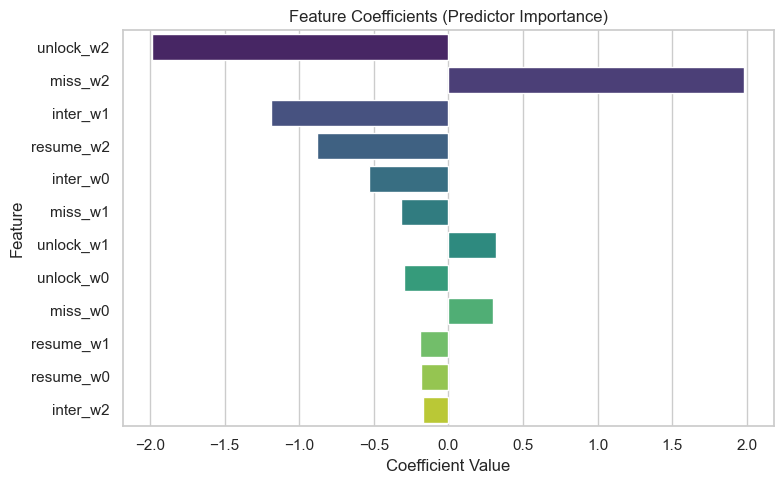

| Metric             | Value         |
|:-------------------|:--------------|
| Test Accuracy      | 0.906         |
| Test ROC AUC       | 0.947         |
| 5-fold CV Accuracy | 0.931 ± 0.023 |
| 5-fold CV ROC AUC  | 0.940 ± 0.036 |

Key Findings:
- Week 2 metrics (unlock vs. miss) are most predictive of dropout.
- An early‐warning alarm at week 2 could enable timely interventions for high‐risk users.
- Incorporating interaction and resume features raised model AUC from ~0.90 to ~0.95.


In [181]:
!pip install tabulate

# ── 1) 피처 계수 (회귀 계수) 준비 ───────────────────────────────
feature_importances = pd.Series({
    'unlock_w2': -1.984028,
    'miss_w2':  1.984028,
    'inter_w1': -1.185981,
    'resume_w2':-0.880392,
    'inter_w0': -0.533098,
    'miss_w1':  -0.316453,
    'unlock_w1': 0.316453,
    'unlock_w0':-0.297800,
    'miss_w0':   0.297800,
    'resume_w1':-0.192573,
    'resume_w0':-0.185548,
    'inter_w2': -0.171322
})

# ── Figure: 피처 계수 막대그래프 ────────────────────────────────
plt.figure(figsize=(8,5))
sns.barplot(
    x=feature_importances.values,
    y=feature_importances.index,
    palette='viridis'
)
plt.title('Feature Coefficients (Predictor Importance)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('feature_coefficients.png', dpi=300)
plt.show()

# ── 2) 모델 성능 요약 테이블 준비 ──────────────────────────────
performance_summary = pd.DataFrame({
    'Metric': [
        'Test Accuracy',
        'Test ROC AUC',
        '5-fold CV Accuracy',
        '5-fold CV ROC AUC'
    ],
    'Value': [
        '0.906',
        '0.947',
        '0.931 ± 0.023',
        '0.940 ± 0.036'
    ]
})

# 노션에 표로 복사할 수 있도록 출력
print(performance_summary.to_markdown(index=False))

# ── 3) Key Findings 텍스트 출력 ───────────────────────────────
key_findings = [
    "Week 2 metrics (unlock vs. miss) are most predictive of dropout.",
    "An early‐warning alarm at week 2 could enable timely interventions for high‐risk users.",
    "Incorporating interaction and resume features raised model AUC from ~0.90 to ~0.95."
]
print("\nKey Findings:")
for line in key_findings:
    print(f"- {line}")